In [2]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
#from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

#Reload a fresh Keras model from the saved model

In [3]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
#from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from sklearn import metrics
import librosa as lb
import IPython.display as ipd
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
#Se define funcion para extrar las caracteristicas con la librería librosa, obetiendo los coeficientes ceptrales de frecuencia de Mel
#Se realiza un pading en el tamaño para que concuerden los tamaños de las caracteristicas de entrada al modelo.
max_pad_len = 174
def extract_features(file_name):

    try:
        audio, sample_rate = librosa.load(file_name, res_type='soxr_hq')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None

    return mfccs

In [5]:
def predict(path, model):
    num_rows = 40
    num_columns = 174
    num_channels = 1
    audio = extract_features(path)
    audioP = audio.reshape(1, num_rows, num_columns, num_channels)
    probOut = model.predict(audioP)[0]
    indexMax = np.argmax(probOut)
    print(probOut)
    print(indexMax)
    maxProb = probOut[indexMax]
    if(maxProb>0.60):
      if(indexMax==0):
        classP = 'gun_shot'
      elif(indexMax==1):
        classP = 'non_gun_shot'
      else:
        classP = 'new_class'
    else:
      classP = 'None'
    print('Class predicted :',classP,'\n\n')
    return ipd.Audio(path)

In [6]:
soundSirenPath = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio/fold7/102853-8-0-1.wav"
soundScreamPath = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/sounds-screams/good/38_scream.wav"
soundGunshotPath = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio/fold1/102305-6-0-0.wav"
soundNonEventPath = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/sounds-explosions/explosions/explosion_149.wav"



modelGunshot = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/saved_gunshot')
modelScream = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/scream/saved_scream')
modelSiren = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/siren/saved_siren')

# Check its architecture
modelGunshot.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 19, 86, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 19, 86, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 42, 32)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 9, 42, 32)         0

In [7]:
#MODELS PATHS

modelGunshotSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/gunshot/saved_gunshot_1'
modelScreamSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/scream/saved_scream_1'
modelSirenSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/siren/saved_siren_1'


modelGunshot = tf.keras.models.load_model(modelGunshotSave_path)
modelScream = tf.keras.models.load_model(modelScreamSave_path)
modelSiren = tf.keras.models.load_model(modelSirenSave_path)

#Obteniendo y Graficando los filtros del modelo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_conv_filters(model):
    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]

    for layer_name in layer_names:
        layer = model.get_layer(layer_name)
        filters, biases = layer.get_weights()
        n_filters = filters.shape[3]
        filter_size = filters.shape[0]

        # Normalize filters for proper display
        #filters = (filters - np.min(filters)) / (np.max(filters) - np.min(filters))

        # Create a grid to display the filters
        n_cols = 8
        n_rows = int(np.ceil(n_filters / n_cols))

        plt.figure(figsize=(2*n_cols, 2*n_rows))

        # Iterate over the filters
        for i in range(n_filters):
            plt.subplot(n_rows, n_cols, i + 1)
            plt.imshow(filters[:, :, 0, i], cmap='gray')
            plt.axis('off')
            plt.title('Filter {}'.format(i + 1))

            # Get the rounded values of the filter
            rounded_values = np.round(filters[:, :, 0, i], decimals=4)

            # Display the values as labels on the filter
            for (x, y), value in np.ndenumerate(rounded_values):
                plt.text(y, x, value, color='r', ha='center', va='center')

        plt.suptitle(layer_name)
        plt.tight_layout()
        plt.show()

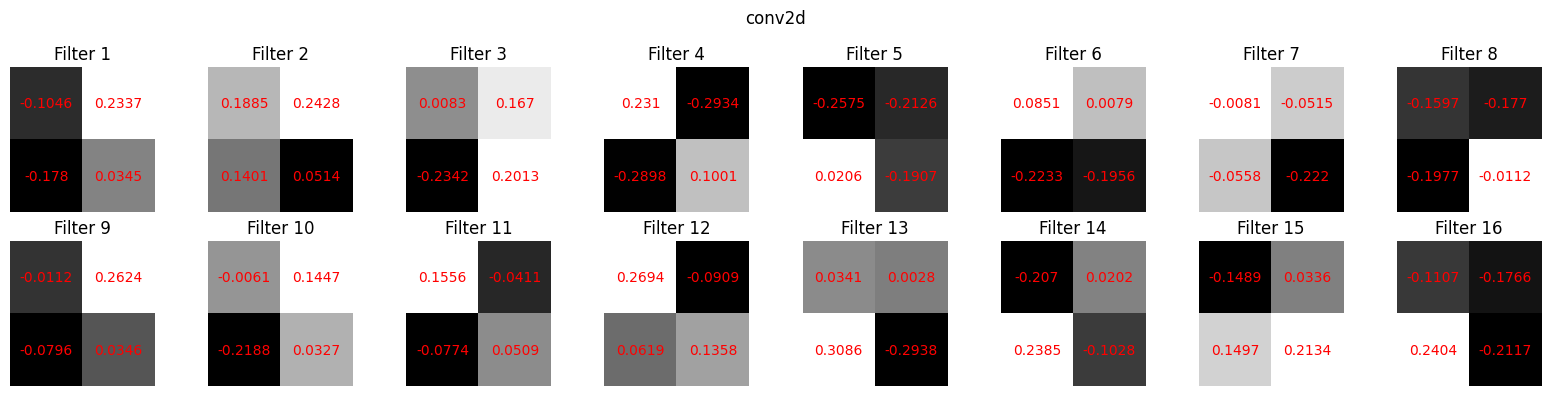

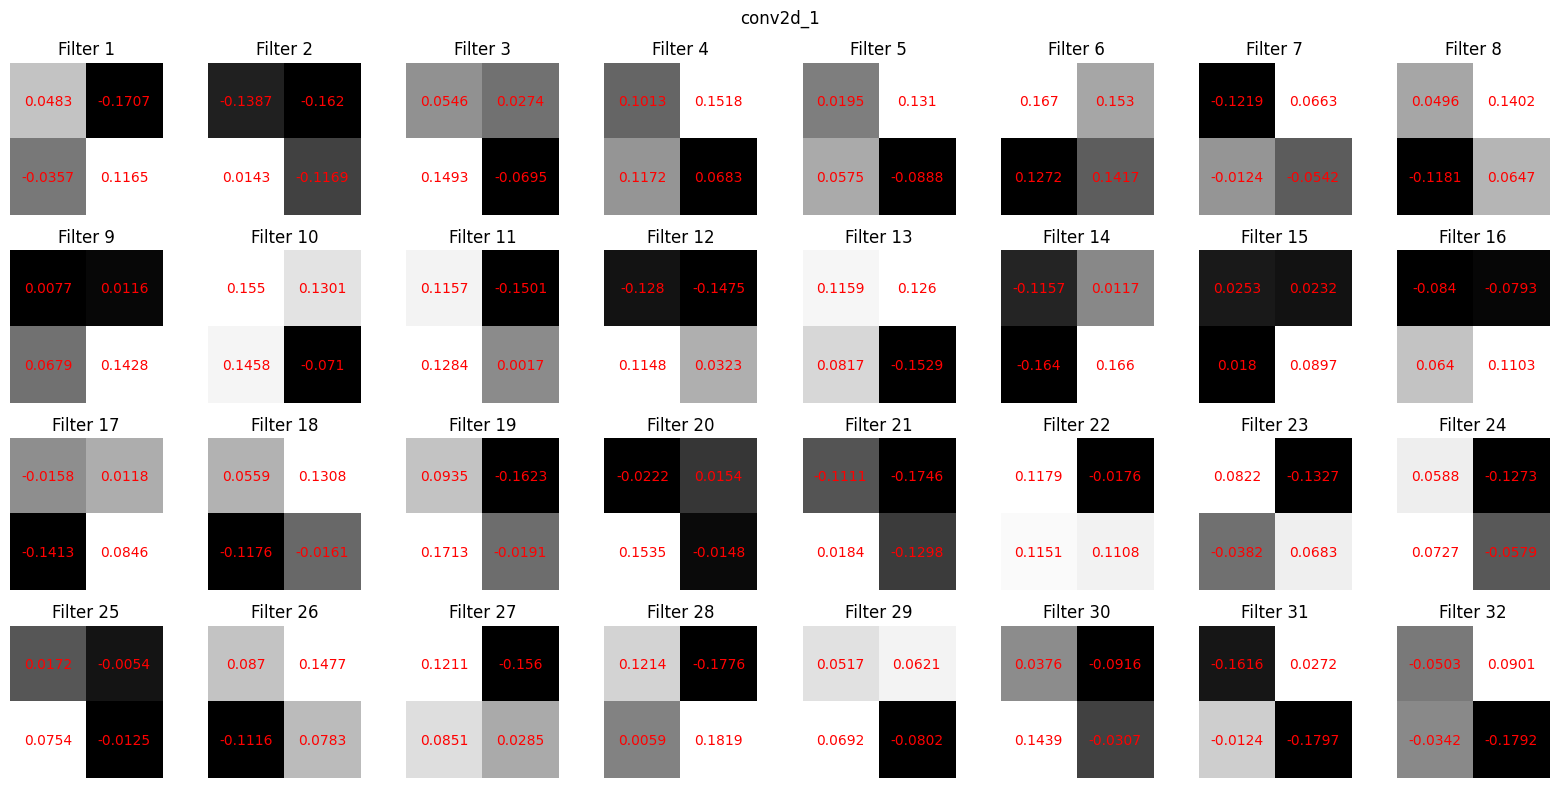

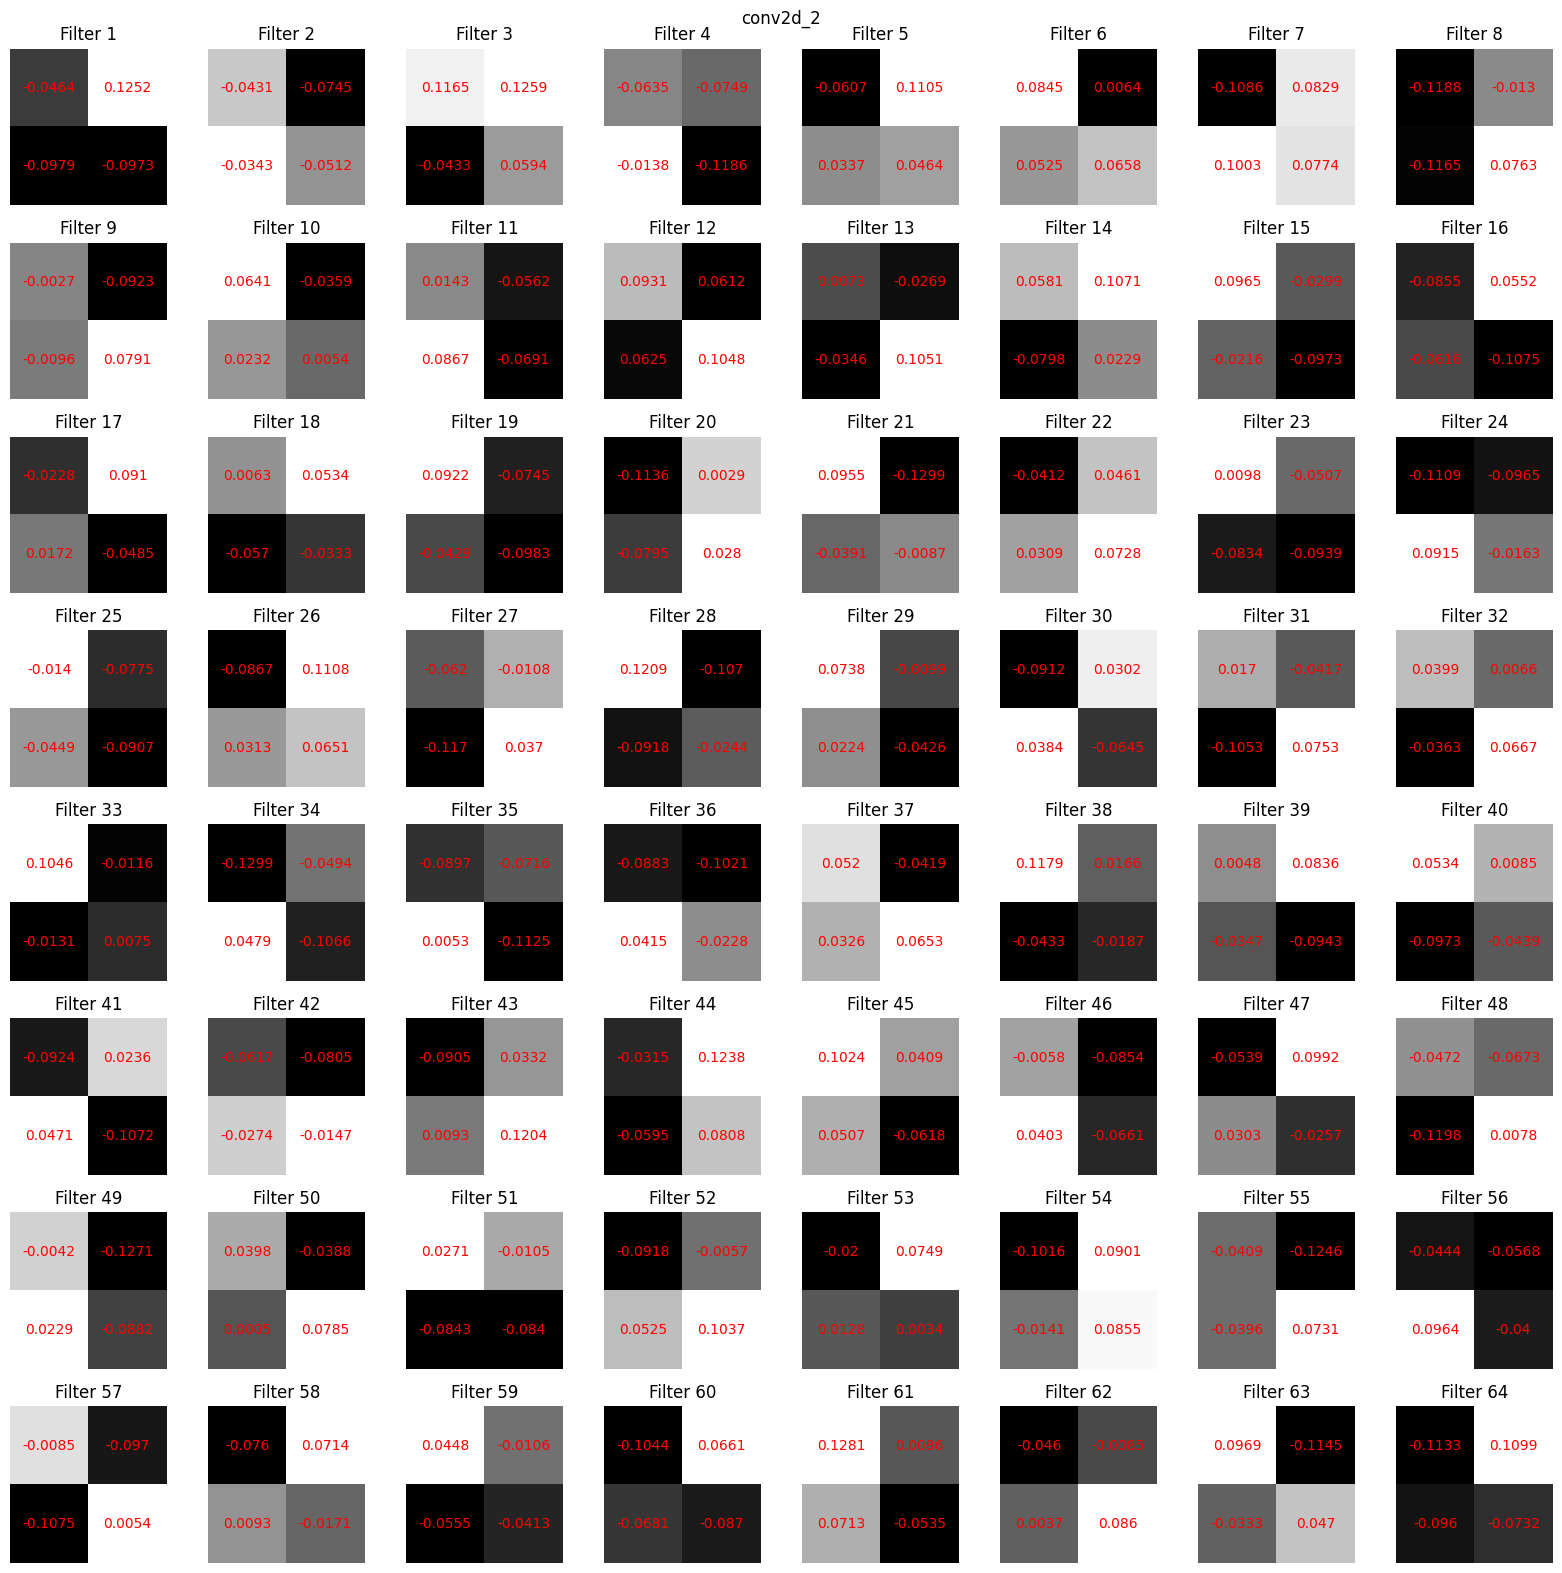

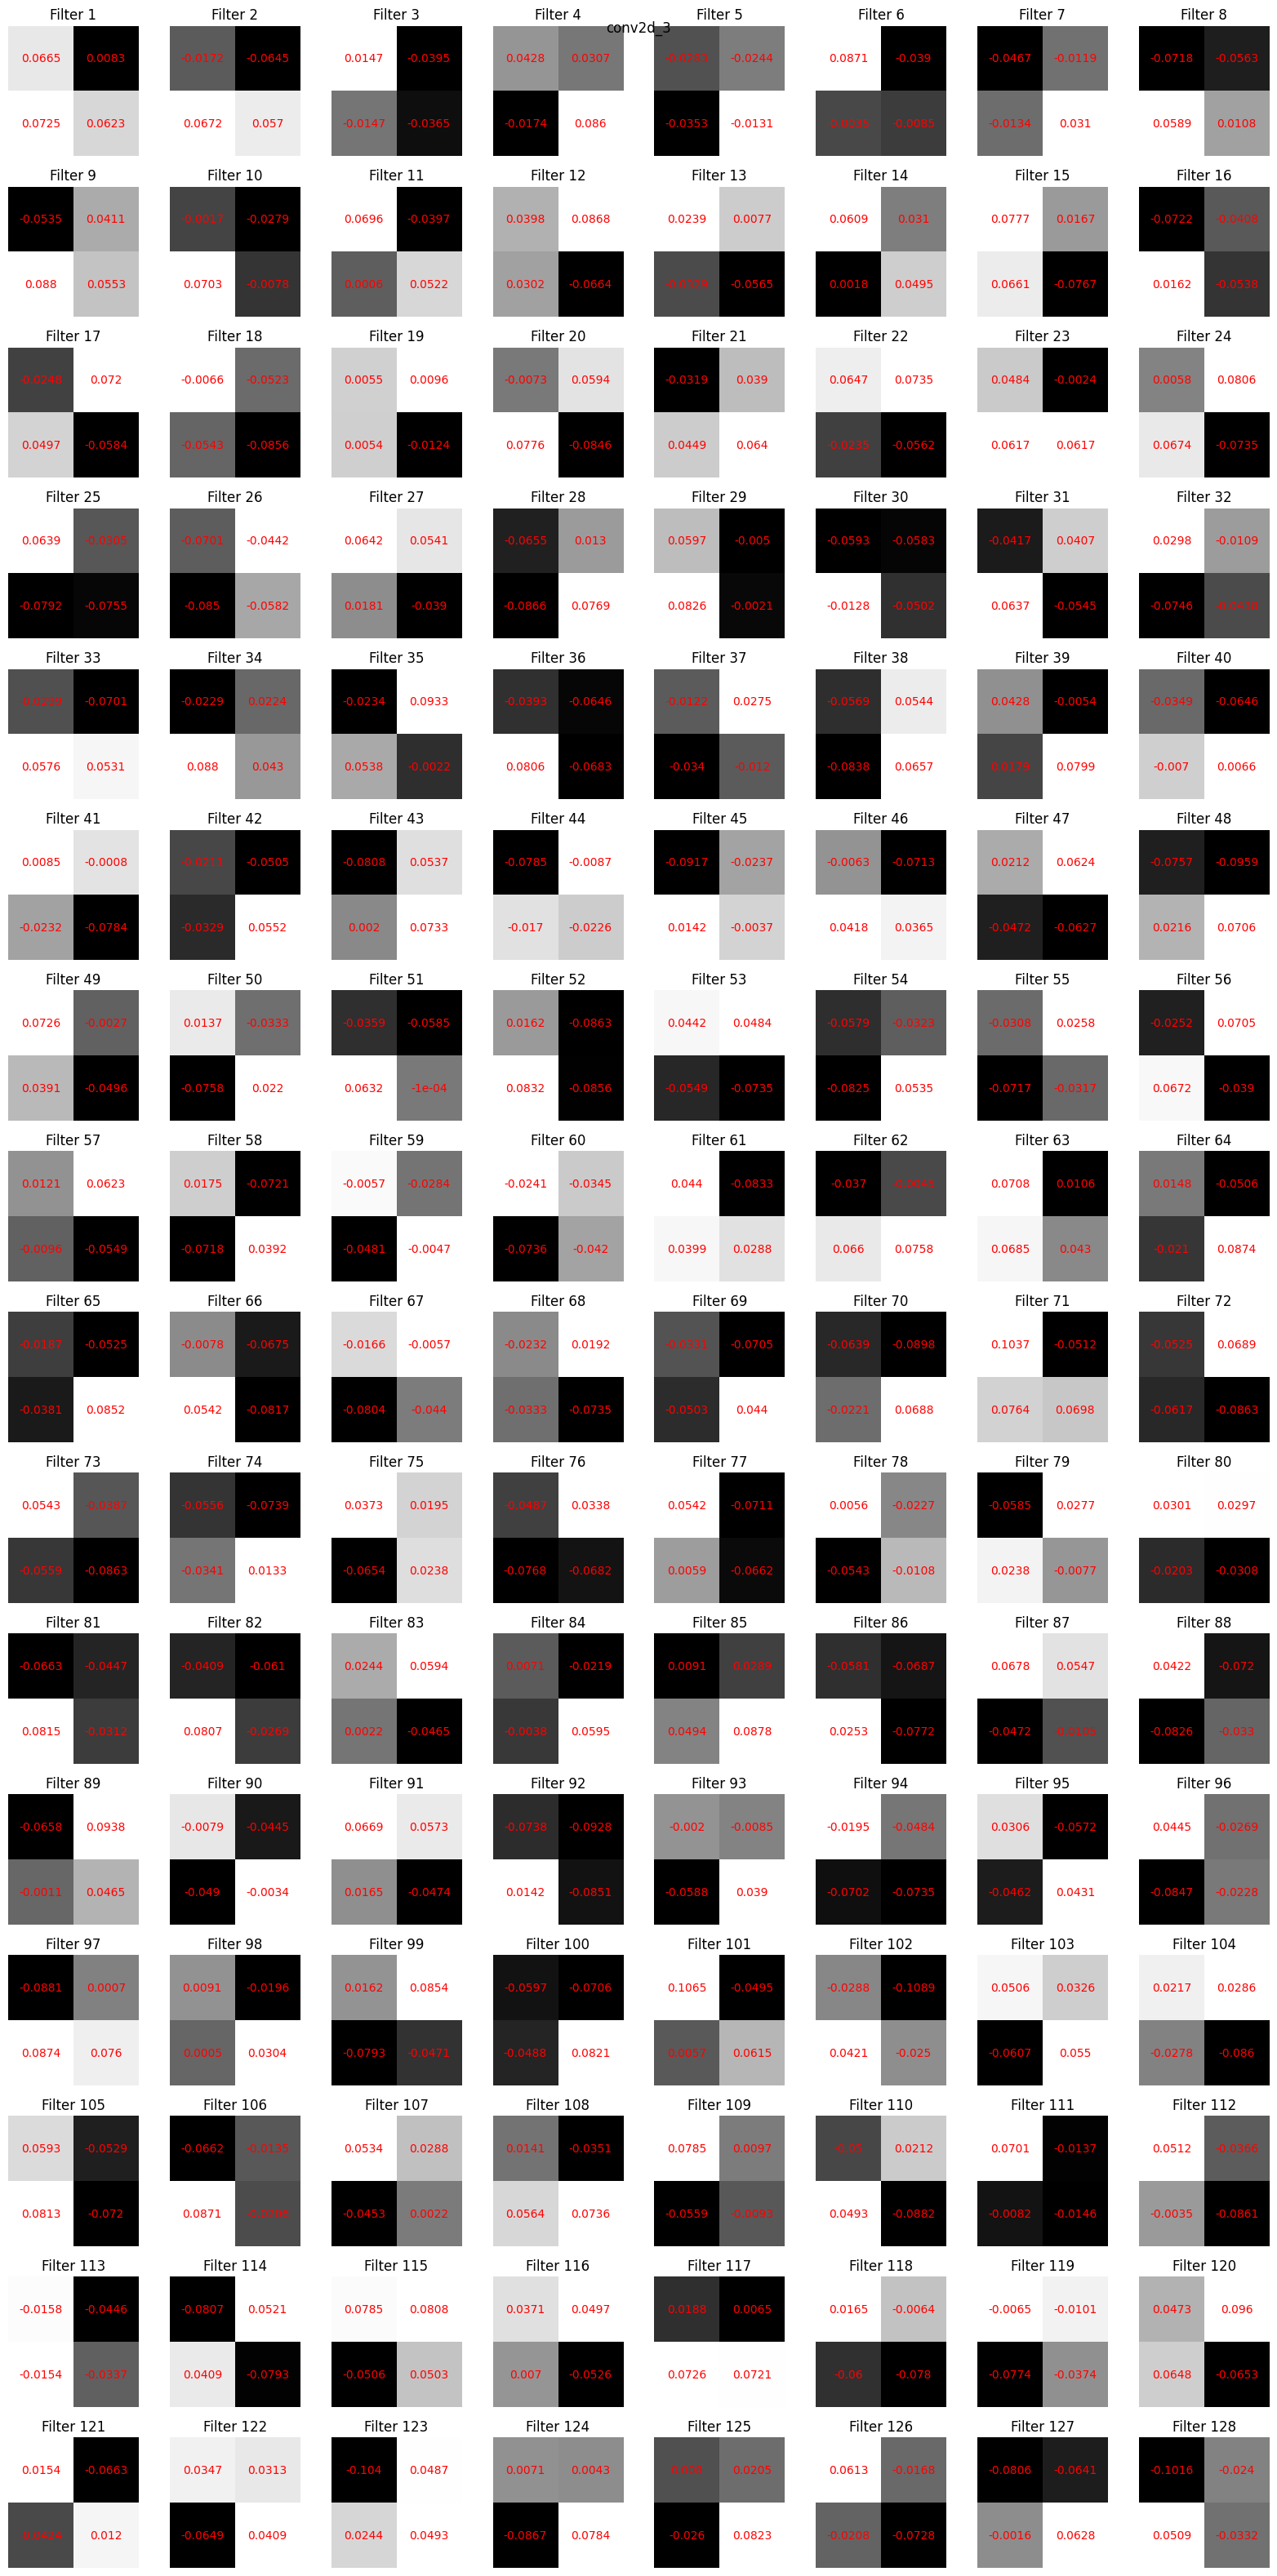

In [ ]:
# llamado a la función
plot_conv_filters(modelGunshot)

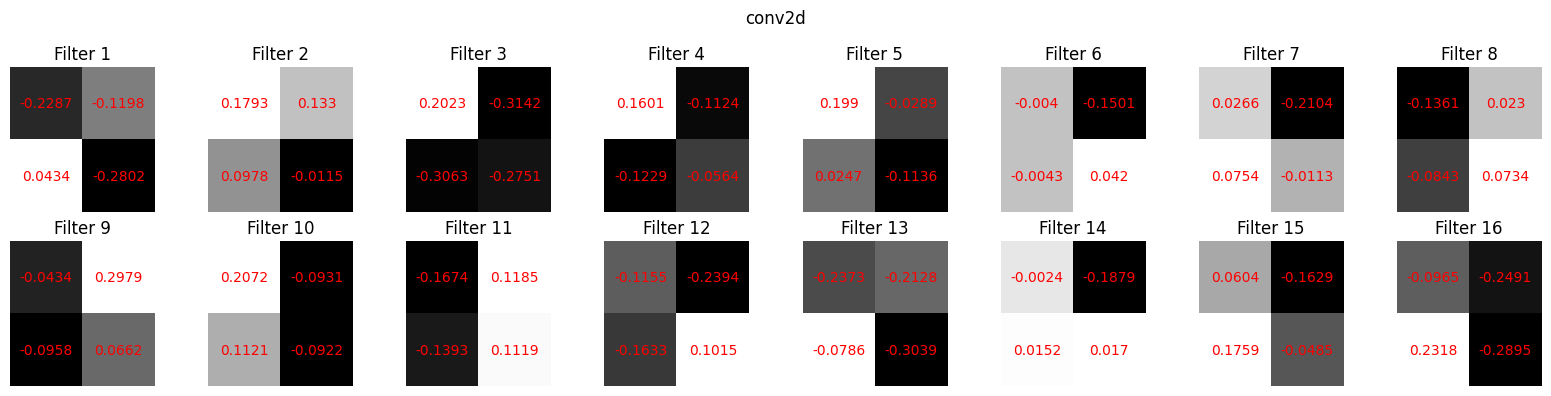

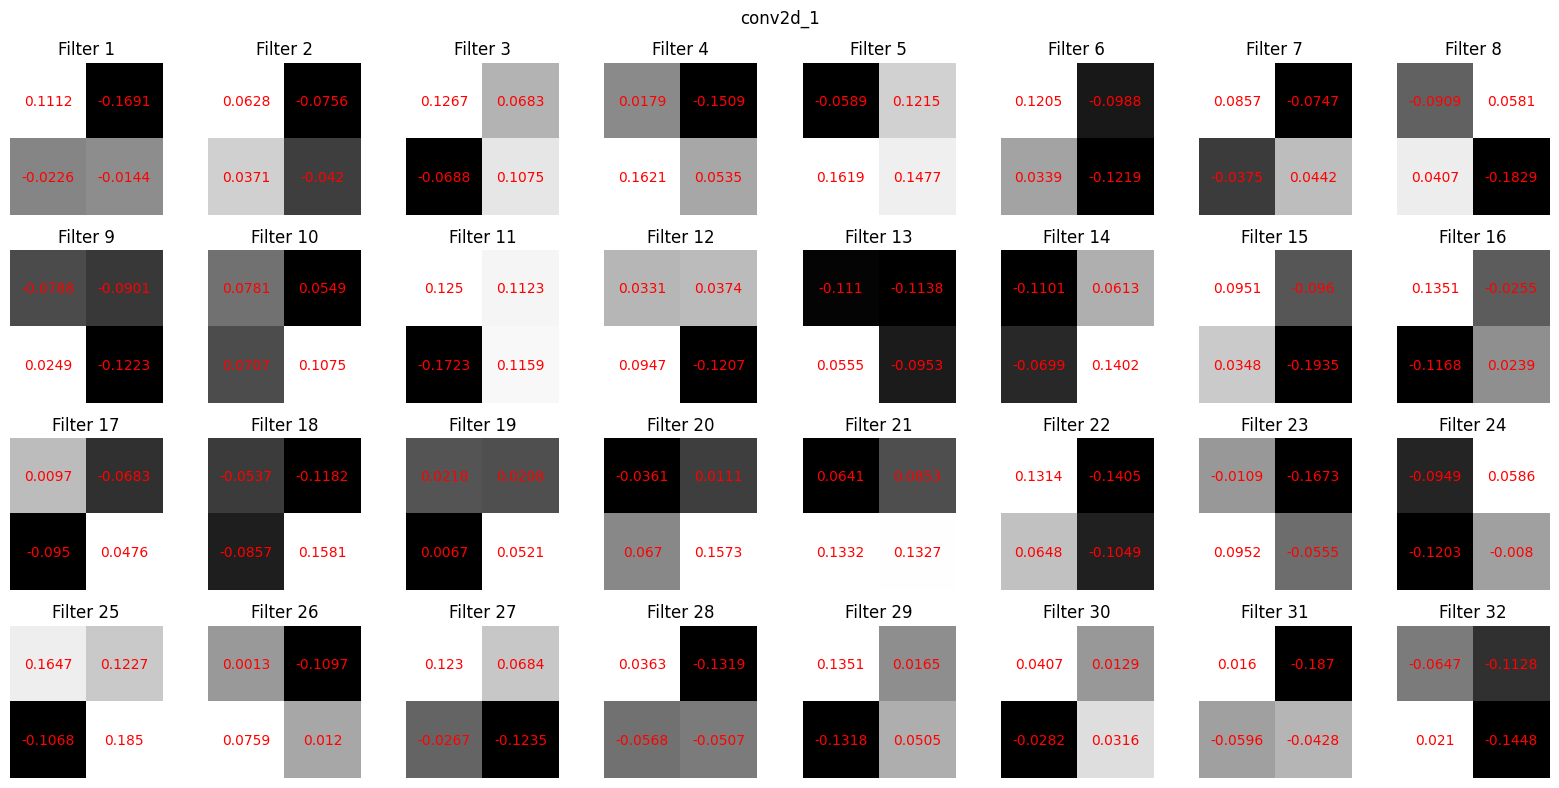

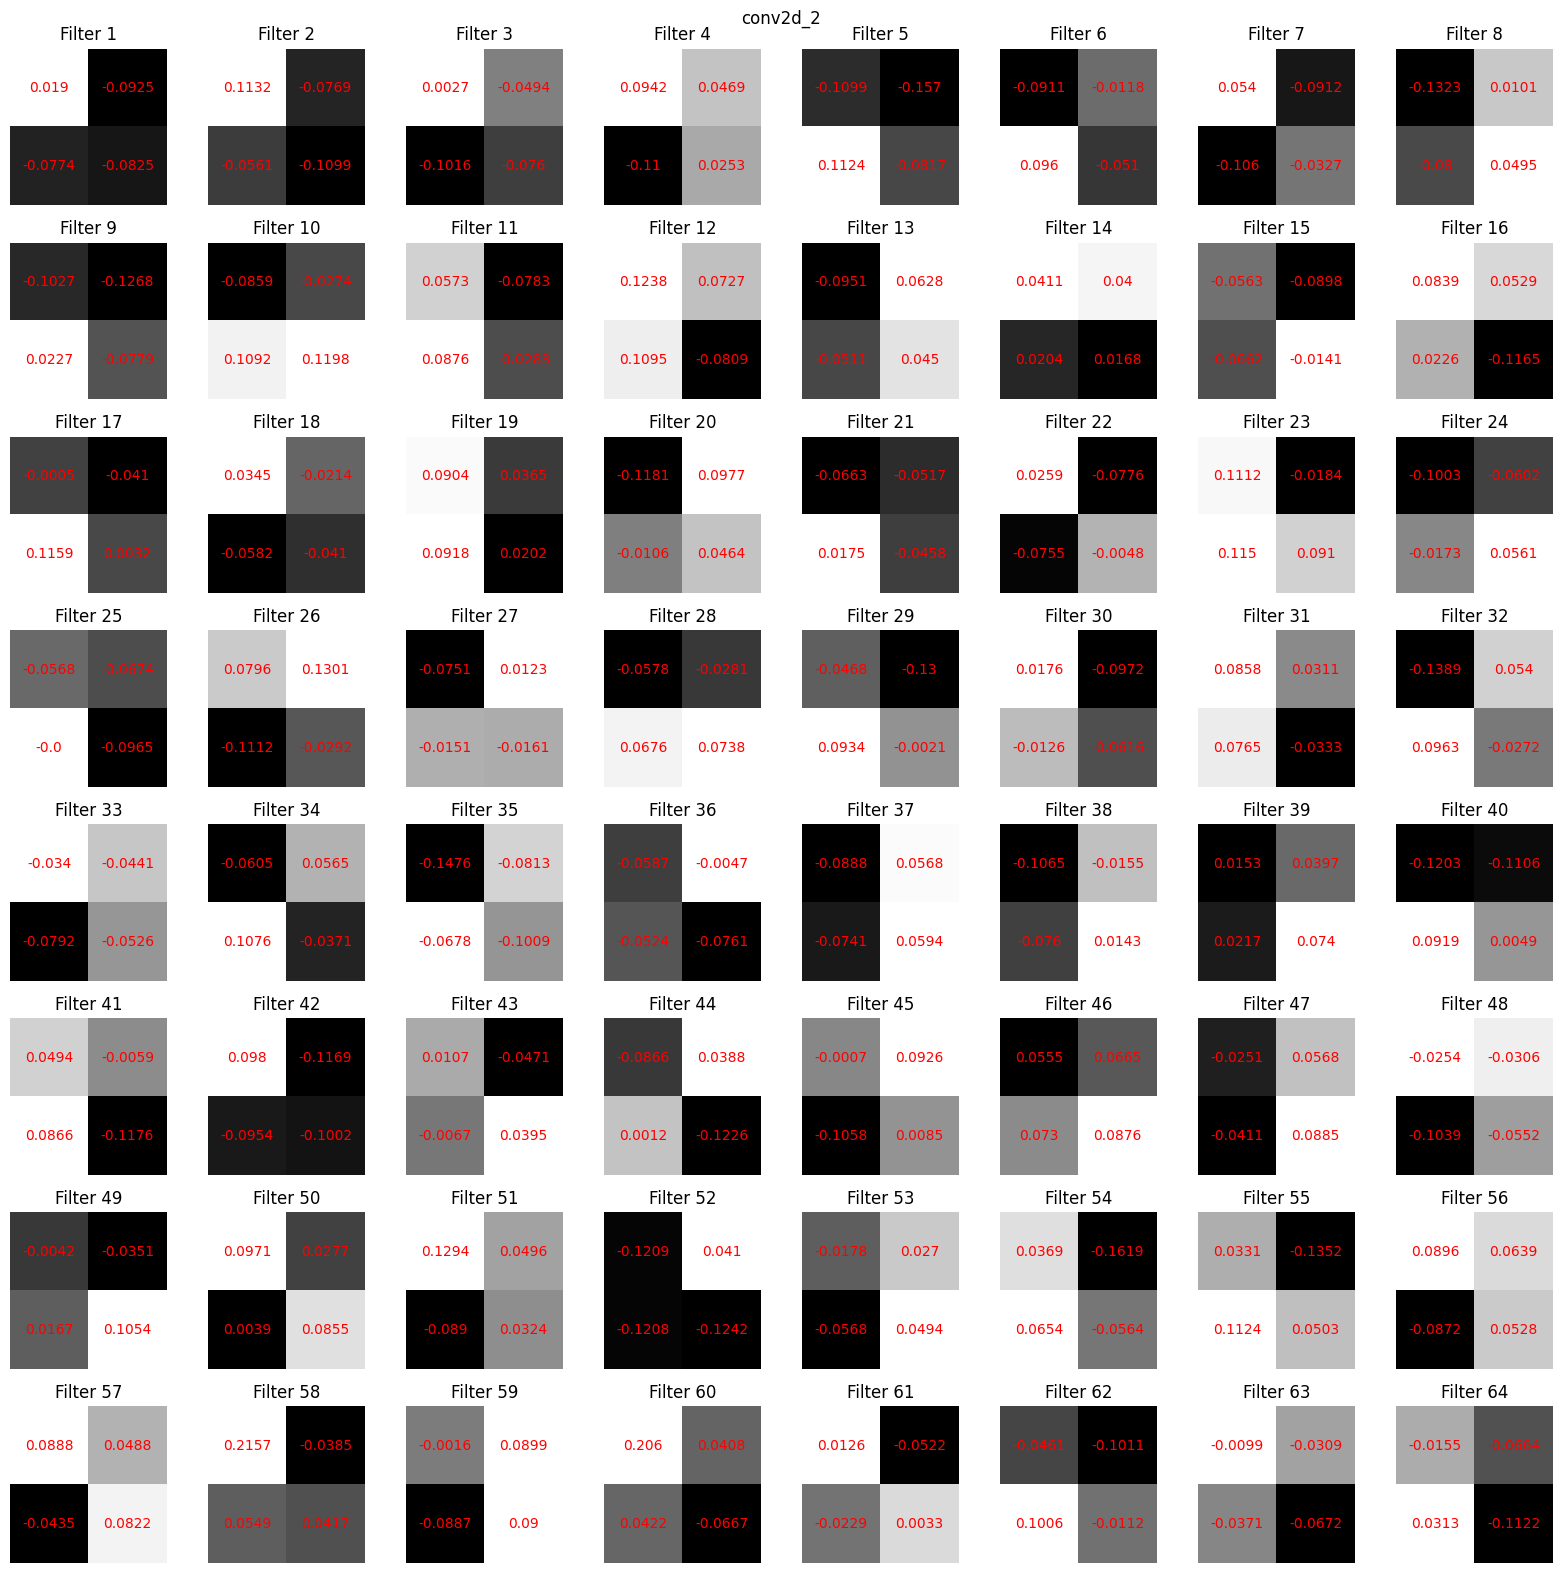

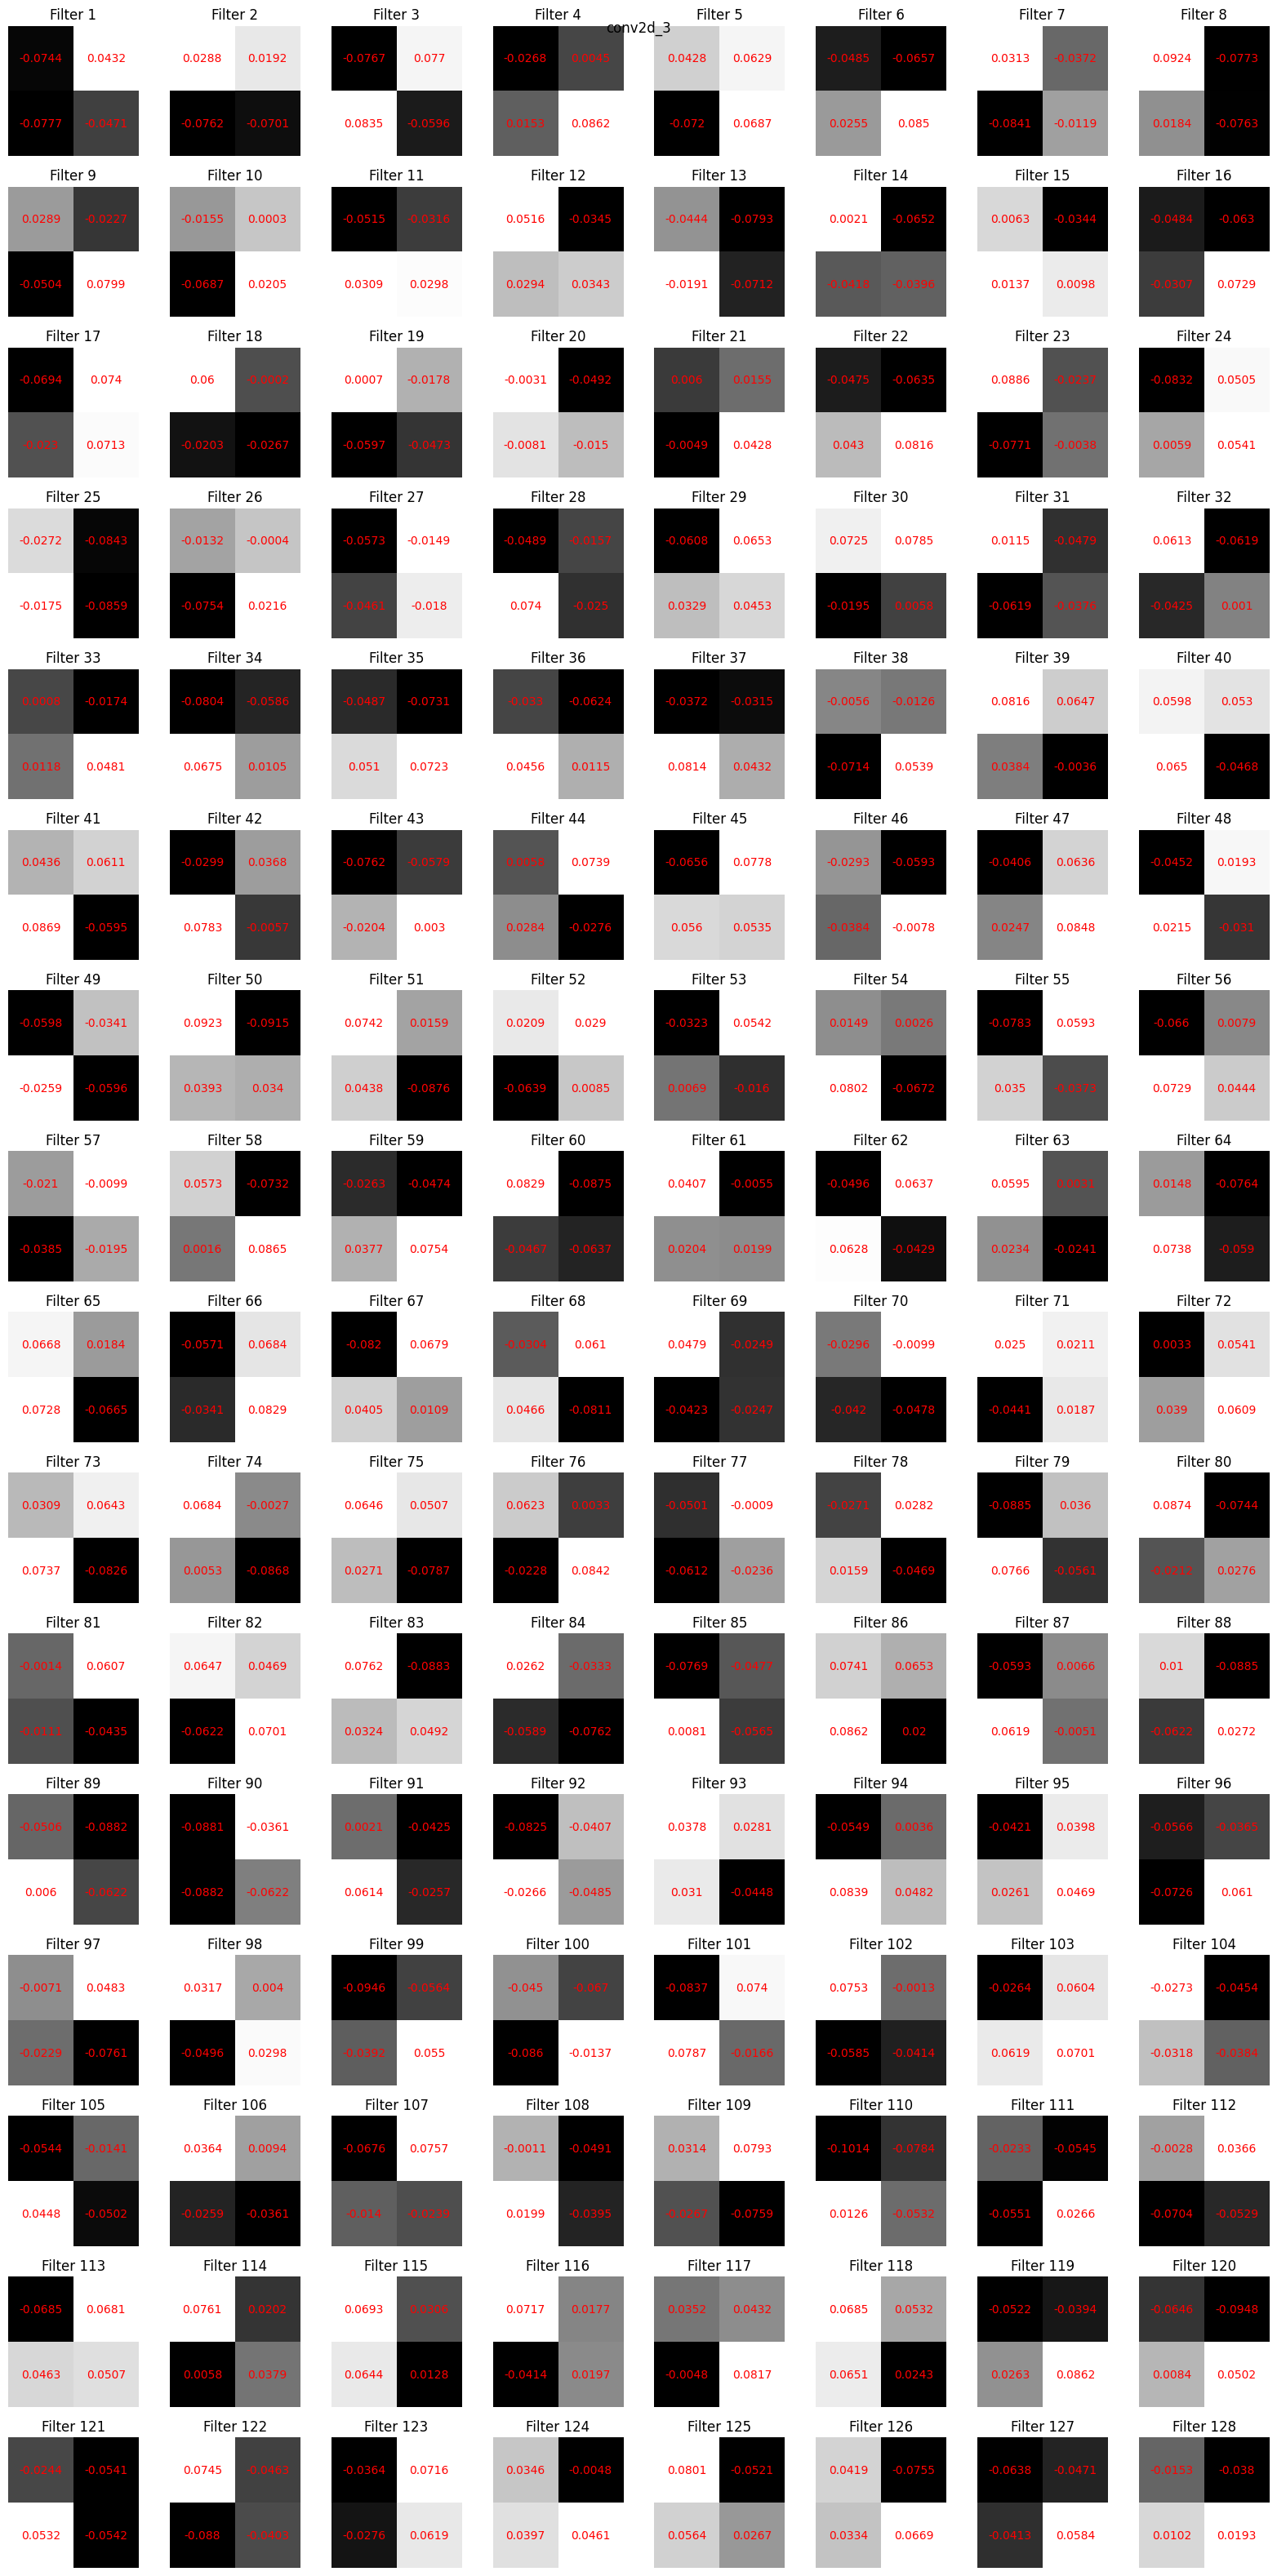

In [ ]:
# llamado a la función
plot_conv_filters(modelScream)

#Obteniendo y Graficando las Diferencias de los Filtros entre Dos Modelos CNN

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

def plot_conv_filters_diff(model1, model2):
    layer_names = [layer.name for layer in model1.layers if 'conv' in layer.name]

    for layer_name in layer_names:
        layer1 = model1.get_layer(layer_name)
        filters1, _ = layer1.get_weights()

        layer2 = model2.get_layer(layer_name)
        filters2, _ = layer2.get_weights()

        n_filters = filters1.shape[3]
        filter_size = filters1.shape[0]

        # Calculate the residual difference between the filters
        filters_diff = abs(filters2 - filters1)

        # Normalize the filters for proper display
        #filters_diff = (filters_diff - np.min(filters_diff)) / (np.max(filters_diff) - np.min(filters_diff))

        # Create a grid to display the filters
        n_cols = 8
        n_rows = int(np.ceil(n_filters / n_cols))

        plt.figure(figsize=(2 * n_cols, 2 * n_rows))

        # Iterate over the filters
        for i in range(n_filters):
            plt.subplot(n_rows, n_cols, i + 1)
            plt.imshow(filters_diff[:, :, 0, i], cmap='gray')
            plt.axis('off')
            plt.title('Filter {}'.format(i + 1))

            # Get the rounded values of the filter difference
            rounded_values = np.round(filters_diff[:, :, 0, i], decimals=4)

            # Display the values as labels on the filter difference
            for (x, y), value in np.ndenumerate(rounded_values):
                plt.text(y, x, value, color='r', ha='center', va='center')

        plt.suptitle(layer_name)
        plt.tight_layout()
        plt.show()

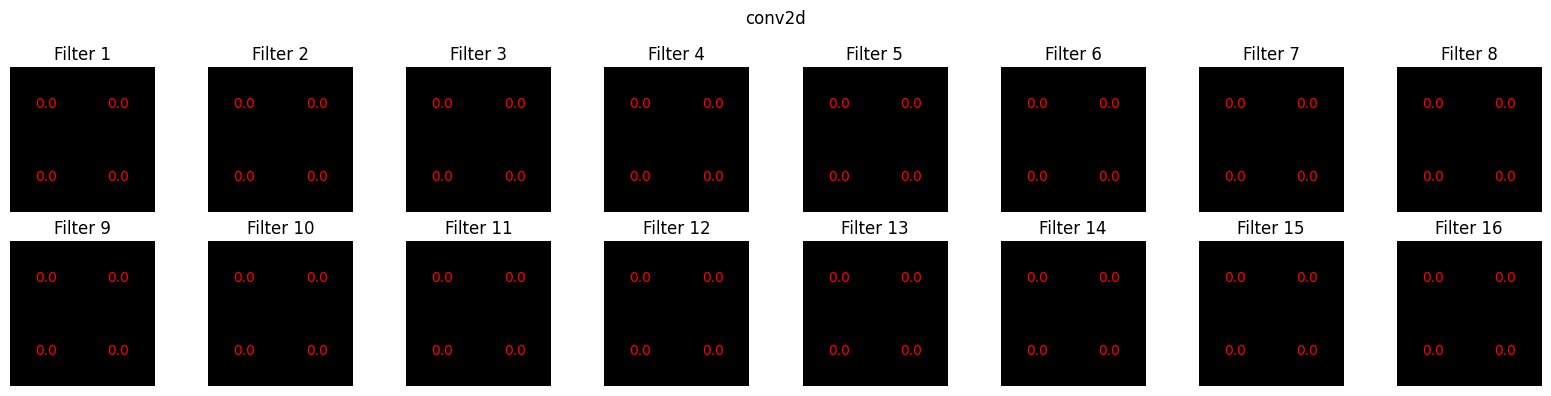

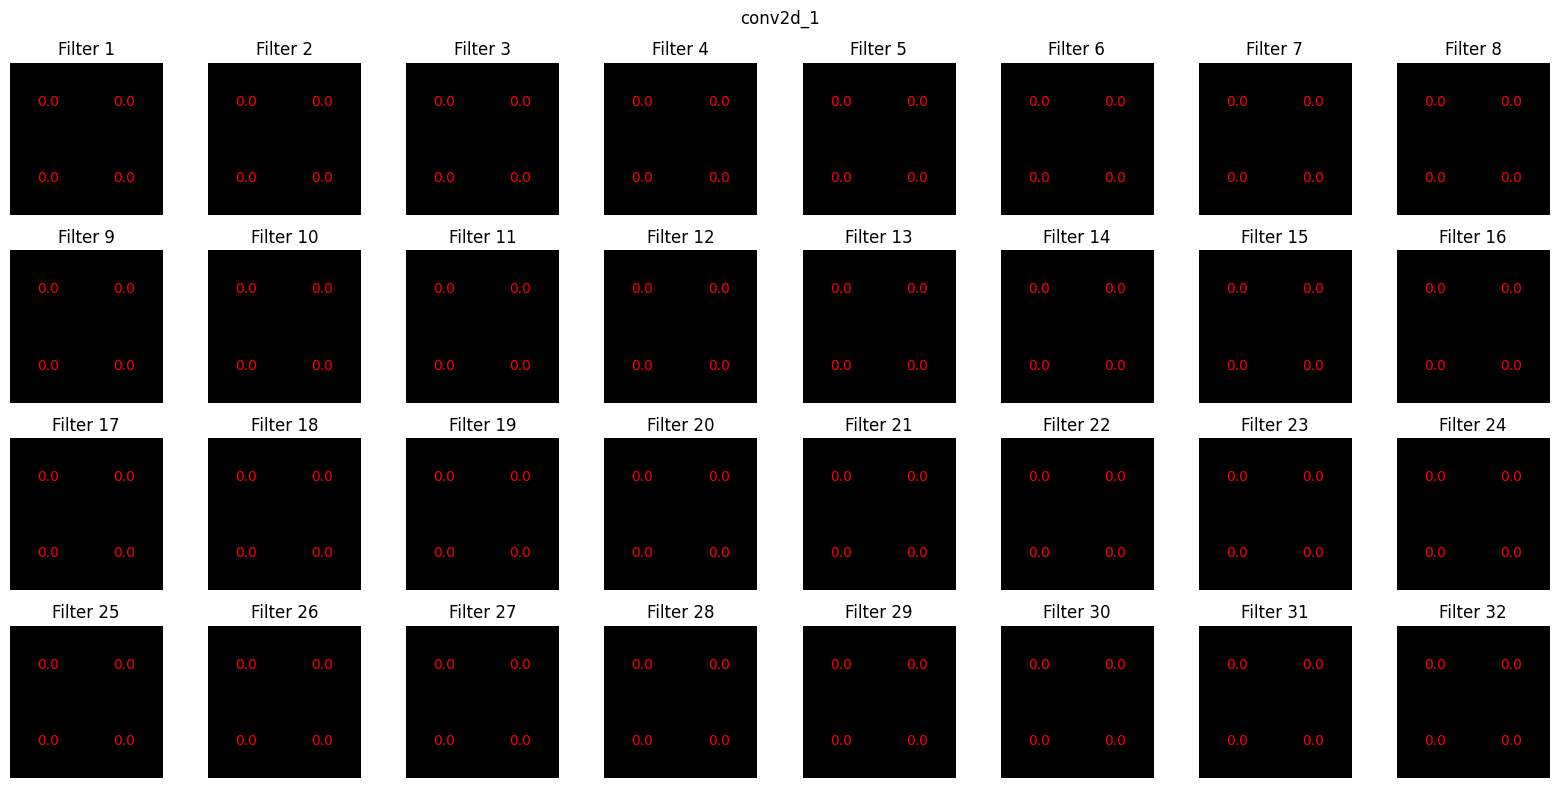

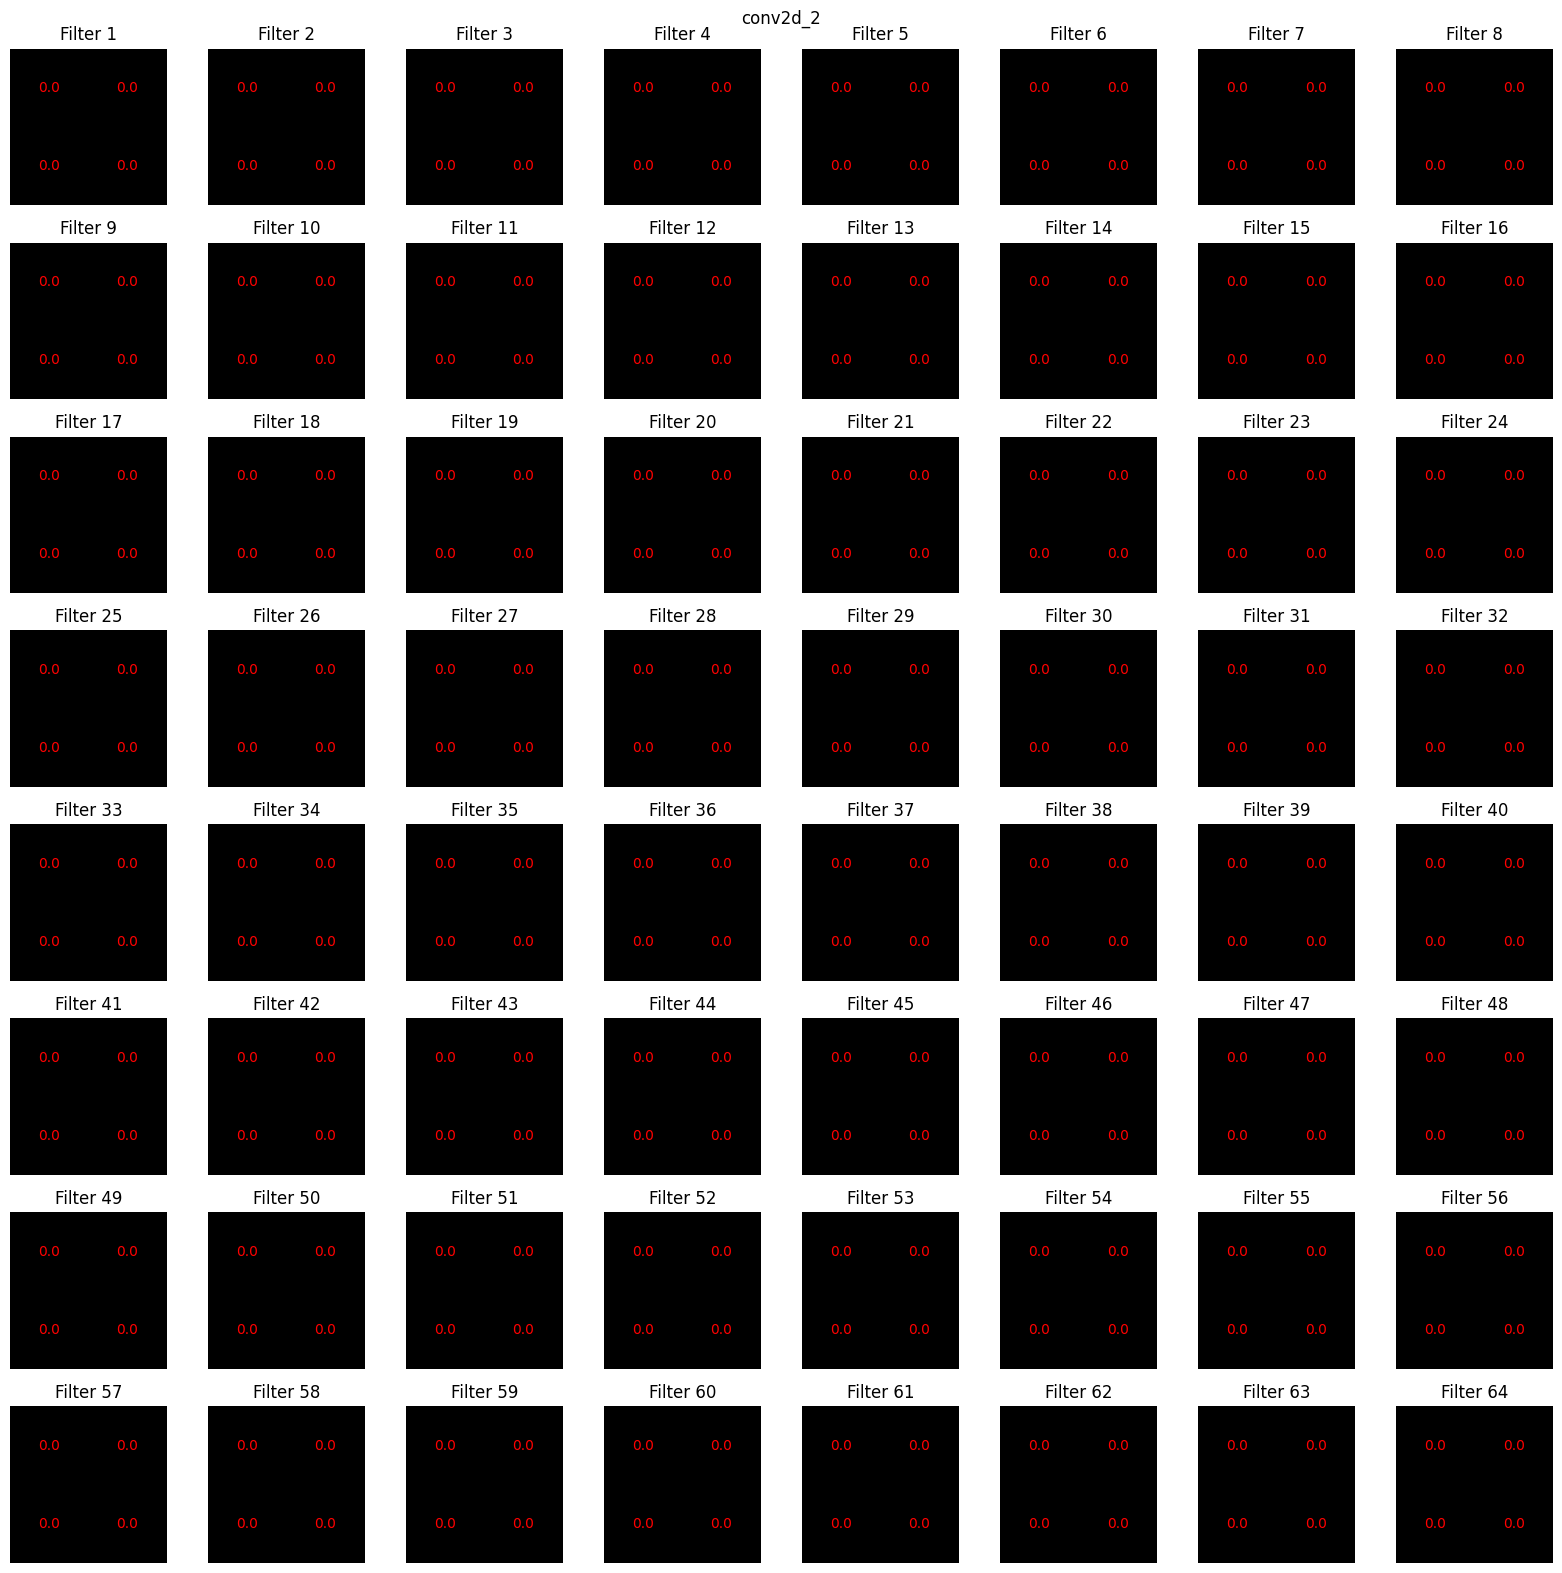

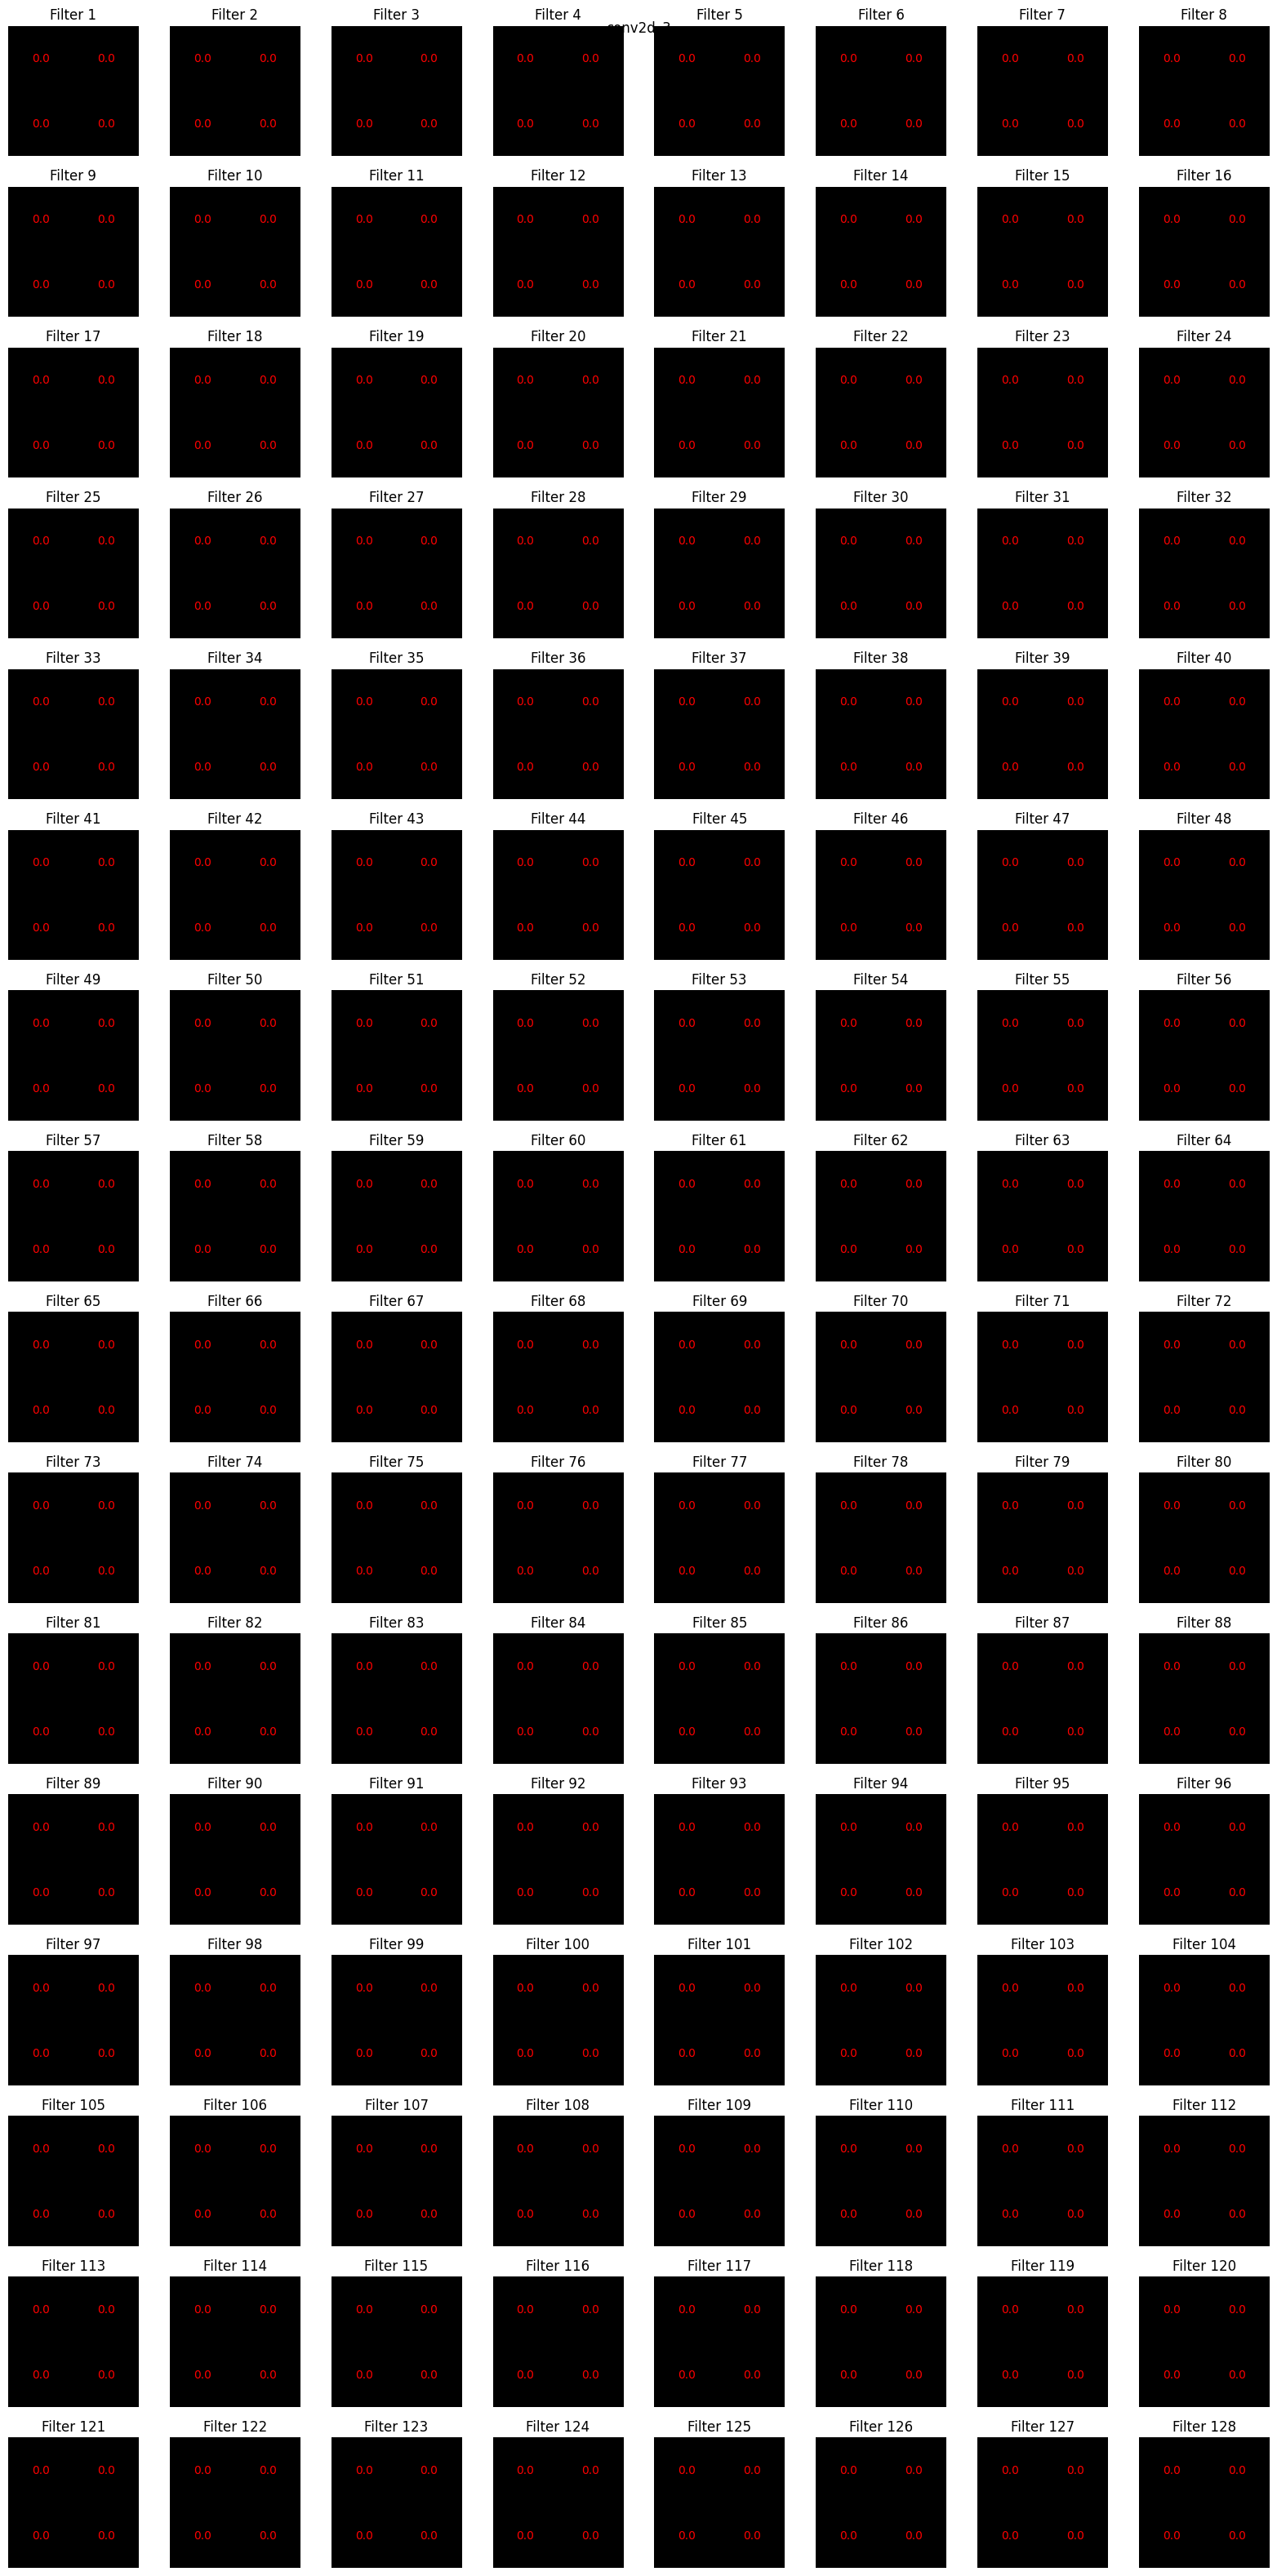

In [ ]:
# llamado a la función
plot_conv_filters_diff(modelGunshot, modelGunshot)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_conv_filters_diff(model1, model2, layer_index):
    layer_names = [layer.name for layer in model1.layers if 'conv' in layer.name]

    if layer_index < 0 or layer_index >= len(layer_names):
        print("Invalid layer index.")
        return

    layer_name = layer_names[layer_index]

    layer1 = model1.get_layer(layer_name)
    filters1, _ = layer1.get_weights()

    layer2 = model2.get_layer(layer_name)
    filters2, _ = layer2.get_weights()

    n_filters = filters1.shape[3]
    filter_size = filters1.shape[0]

    # Calculate the residual difference between the filters
    filters_diff = abs(filters2 - filters1)

    # Normalize the filters for proper display
    # filters_diff = (filters_diff - np.min(filters_diff)) / (np.max(filters_diff) - np.min(filters_diff))

    # Create a grid to display the filters
    n_cols = 8
    n_rows = int(np.ceil(n_filters / n_cols))

    plt.figure(figsize=(2 * n_cols, 2 * n_rows))

    # Iterate over the filters
    for i in range(n_filters):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(filters_diff[:, :, 0, i], cmap='gray')
        plt.axis('off')
        plt.title('Filter {}'.format(i + 1))

        # Get the rounded values of the filter difference
        rounded_values = np.round(filters_diff[:, :, 0, i], decimals=4)

        # Display the values as labels on the filter difference
        for (x, y), value in np.ndenumerate(rounded_values):
            plt.text(y, x, value, color='r', ha='center', va='center')

    plt.suptitle(layer_name)
    plt.tight_layout()
    plt.show()


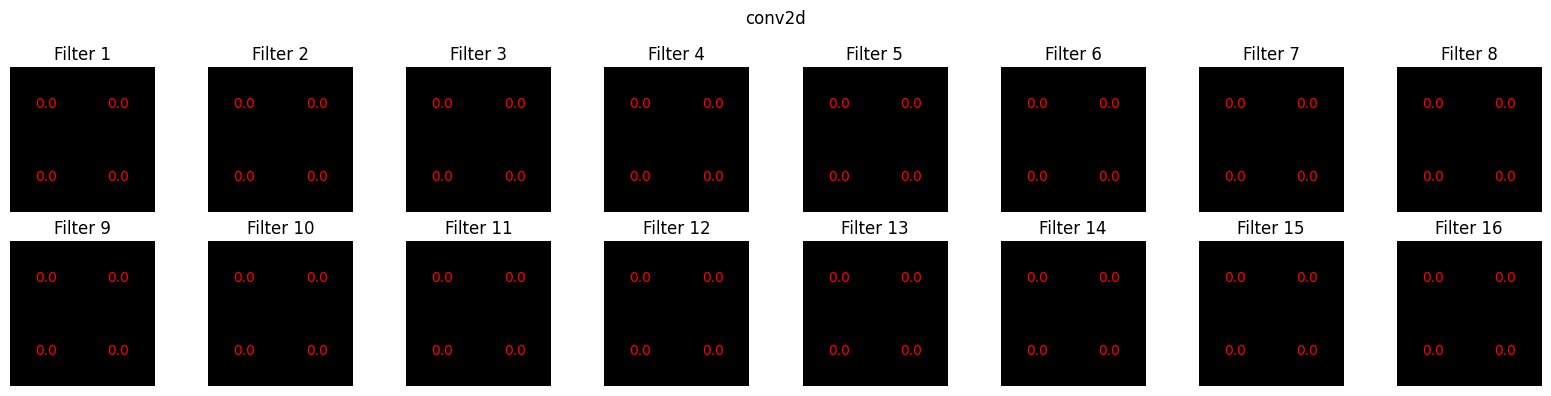

In [ ]:
# llamado a la función
plot_conv_filters_diff(modelGunshot, modelGunshot, 0)

#Obteniendo y Almacenando Ranking Similitud de los Filtros de una Capa entre Dos Modelos CNN - METRICA 1 - SIN NORMALIZAR

In [8]:
import numpy as np
import pandas as pd
from scipy.ndimage import rotate

def plot_conv_filters_diff(model1, model2, layer_index, differenceDataOutPath):
    layer_names = [layer.name for layer in model1.layers if 'conv' in layer.name]

    if layer_index < 0 or layer_index >= len(layer_names):
        print("Invalid layer index.")
        return

    layer_name = layer_names[layer_index]

    layer1 = model1.get_layer(layer_name)
    filters1, _ = layer1.get_weights()

    layer2 = model2.get_layer(layer_name)
    filters2, _ = layer2.get_weights()

    n_filters1 = filters1.shape[3]
    n_filters2 = filters2.shape[3]

    rotations = [0, 90, 180, 270]

    # Calculate the residual difference between the filters
    # Calculate the residual difference between the filters
    sum_diff = np.zeros((n_filters1, n_filters2, len(rotations) + 2))
    filter_number_m1 = []
    filter_number_m2 = []
    layer_index_m1 = []
    layer_index_m2 = []
    rotations_used = []
    reflections_used = []
    for i in range(n_filters1):
        for j in range(n_filters2):

            # Angle Rotations of filter1
            for k, angle in enumerate(rotations):
                rotated_filters1 = rotate(filters1[:, :, :, i], angle, axes=(0, 1), reshape=False)
                norm_filters1 = np.linalg.norm(rotated_filters1)
                norm_filters2 = np.linalg.norm(filters2[:, :, :, j])
                diff = np.linalg.norm(rotated_filters1 - filters2[:, :, :, j]) / np.average(norm_filters1 + norm_filters2)
                sum_diff[i, j, k] = 1-diff
                filter_number_m1.append(i+1)
                filter_number_m2.append(j+1)
                layer_index_m1.append(layer_index+1)
                layer_index_m2.append(layer_index+1)
                #filter_pairs.append("Filter {} vs Filter {}".format(i + 1, j + 1))
                rotations_used.append(angle)
                reflections_used.append(0)

            # Vertical Reflection of filter1
            reflected_filters1_vertical = np.flipud(filters1[:, :, :, i])
            norm_filters1 = np.linalg.norm(reflected_filters1_vertical)
            norm_filters2 = np.linalg.norm(filters2[:, :, :, j])
            diff_vertical = np.linalg.norm(reflected_filters1_vertical - filters2[:, :, :, j]) / np.average(norm_filters1 + norm_filters2)
            sum_diff[i, j, len(rotations)] = 1-diff_vertical
            filter_number_m1.append(i+1)
            filter_number_m2.append(j+1)
            layer_index_m1.append(layer_index+1)
            layer_index_m2.append(layer_index+1)
            #filter_pairs.append("Filter {} vs Filter {}".format(i + 1, j + 1))
            rotations_used.append(0)
            reflections_used.append(1)#Vertical Reflection of filter1

            # Horizontal Reflection of filter1
            reflected_filters1_horizontal = np.fliplr(filters1[:, :, :, i])
            norm_filters1 = np.linalg.norm(reflected_filters1_horizontal)
            norm_filters2 = np.linalg.norm(filters2[:, :, :, j])
            diff_horizontal = np.linalg.norm(reflected_filters1_horizontal - filters2[:, :, :, j]) / np.average(norm_filters1 + norm_filters2)
            sum_diff[i, j, len(rotations) + 1] = 1-diff_horizontal
            filter_number_m1.append(i+1)
            filter_number_m2.append(j+1)
            layer_index_m1.append(layer_index+1)
            layer_index_m2.append(layer_index+1)
            #filter_pairs.append("Filter {} vs Filter {}".format(i + 1, j + 1))
            rotations_used.append(0)
            reflections_used.append(2)#Horizontal Reflection of filter1


    # Create a DataFrame to store the results
    df = pd.DataFrame({'LayerModel1': layer_index_m1, 'FilterModel1': filter_number_m1, 'FilterModel2': filter_number_m2, 'LayerModel2': layer_index_m2, 'Rotation': rotations_used, 'Reflection': reflections_used, 'Similarity': sum_diff.flatten()})

    df.to_excel(differenceDataOutPath)
    print("FILE SAVED CORRECT WAY")
    print(df.shape)
    print(type(df))
    return df

In [ ]:
#MODELS PATHS

modelGunshotSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/gunshot/saved_gunshot_1'
modelScreamSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/scream/saved_scream_1'
modelSirenSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/siren/saved_siren_1'


modelGunshot = tf.keras.models.load_model(modelGunshotSave_path)
modelScream = tf.keras.models.load_model(modelScreamSave_path)
modelSiren = tf.keras.models.load_model(modelSirenSave_path)

In [ ]:
differenceDataOutPath = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Comparison/Metric1/gun_vs_scream/gunshot_vs_scream_Layer3.xlsx"
# llamado a la función
dfGunScream = plot_conv_filters_diff(modelGunshot, modelScream, 3, differenceDataOutPath)
dfGunScream.sort_values(by='Similarity', ascending=False)

FILE SAVED CORRECT WAY
(98304, 7)
<class 'pandas.core.frame.DataFrame'>


,LayerModel1,FilterModel1,FilterModel2,LayerModel2,Rotation,Reflection,Similarity
84252,4,110,91,4,0,0,0.401711
38587,4,51,32,4,90,0,0.394170
4693,4,7,15,4,90,0,0.392867
49230,4,65,14,4,0,0,0.387960
63517,4,83,91,4,90,0,0.385716
...,...,...,...,...,...,...,...
13986,4,19,28,4,0,0,0.213779
41850,4,55,64,4,0,0,0.213158
7896,4,11,37,4,0,0,0.212716
65710,4,86,72,4,0,1,0.209767


In [ ]:
differenceDataOutPath = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Comparison/Metric1/gun_vs_gun_same/gunshot_vs_gunshot_Layer3.xlsx"
# llamado a la función
dfGunGun = plot_conv_filters_diff(modelGunshot, modelGunshot, 3, differenceDataOutPath)
dfGunGun.sort_values(by='Similarity', ascending=False)

FILE SAVED CORRECT WAY
(98304, 7)
<class 'pandas.core.frame.DataFrame'>


,LayerModel1,FilterModel1,FilterModel2,LayerModel2,Rotation,Reflection,Similarity
0,4,1,1,4,0,0,1.000000
34830,4,46,46,4,0,0,1.000000
91332,4,119,119,4,0,0,1.000000
35604,4,47,47,4,0,0,1.000000
42570,4,56,56,4,0,0,1.000000
...,...,...,...,...,...,...,...
24458,4,32,109,4,180,0,0.209923
65591,4,86,52,4,0,2,0.204502
39683,4,52,86,4,0,2,0.204502
95206,4,124,124,4,0,1,0.199574


In [ ]:
#MODELS PATHS

modelGunshotSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/gunshot/saved_gunshot_1'
modelGunshotV2Save_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/gunshot/saved_gunshot_1_V2'
modelGunshot = tf.keras.models.load_model(modelGunshotSave_path)
modelGunshotV2 = tf.keras.models.load_model(modelGunshotV2Save_path)

modelScreamFromGunTLSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL/scream/saved_scream_from_gunshot_1'
modelScreamFromGunTL = tf.keras.models.load_model(modelScreamFromGunTLSave_path)

In [ ]:
differenceDataOutPath = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Comparison/Metric1/gun_vs_gun_diffTrain/gunshot_vs_gunshotV2_Layer3.xlsx"
# llamado a la función
#Layers 0,1,2,3
dfGunGunV2 = plot_conv_filters_diff(modelGunshot, modelGunshotV2, 3, differenceDataOutPath)
dfGunGunV2.sort_values(by='Similarity', ascending=False)

FILE SAVED CORRECT WAY
(98304, 7)
<class 'pandas.core.frame.DataFrame'>


,LayerModel1,FilterModel1,FilterModel2,LayerModel2,Rotation,Reflection,Similarity
52818,4,69,100,4,0,0,0.393967
79782,4,104,114,4,0,0,0.386769
27793,4,37,25,4,90,0,0.384093
1104,4,2,57,4,0,0,0.382923
83205,4,109,44,4,270,0,0.381673
...,...,...,...,...,...,...,...
84690,4,111,36,4,0,0,0.211127
14669,4,20,13,4,0,2,0.210835
68986,4,90,106,4,0,1,0.208843
65564,4,86,48,4,180,0,0.208627


In [ ]:
differenceDataOutPath = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Comparison/Metric1/gun_vs_scream_TL/gunshot_vs_scream_TL_Layer3.xlsx"
# llamado a la función
dfGunScreamTL = plot_conv_filters_diff(modelGunshot, modelScreamFromGunTL, 3, differenceDataOutPath)
dfGunScreamTL.sort_values(by='Similarity', ascending=False)

FILE SAVED CORRECT WAY
(98304, 7)
<class 'pandas.core.frame.DataFrame'>


,LayerModel1,FilterModel1,FilterModel2,LayerModel2,Rotation,Reflection,Similarity
10062,4,14,14,4,0,0,0.958354
37926,4,50,50,4,0,0,0.957942
72756,4,95,95,4,0,0,0.956785
0,4,1,1,4,0,0,0.954619
71982,4,94,94,4,0,0,0.954336
...,...,...,...,...,...,...,...
83132,4,109,32,4,180,0,0.206642
65591,4,86,52,4,0,2,0.203113
39683,4,52,86,4,0,2,0.200935
95206,4,124,124,4,0,1,0.198755


In [ ]:
#MODELS PATHS
#Compare filters of models from TL COMPLETE fot gun and scream

modelGunshotTLSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/gunshot/saved_gunshot_TL_1'
modelGunshotTL = tf.keras.models.load_model(modelGunshotTLSave_path)

modelScreamTLSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/scream/saved_scream_TL_1'
modelScreamTL = tf.keras.models.load_model(modelScreamTLSave_path)

In [ ]:
differenceDataOutPath = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Comparison/Metric1/gun_TL_vs_scream_TL/gunshotTL_vs_screamTL_Layer3.xlsx"
# llamado a la función
#Layers 0,1,2,3
dfGunTLScreamTL = plot_conv_filters_diff(modelGunshotTL, modelScreamTL, 3, differenceDataOutPath)
dfGunTLScreamTL.sort_values(by='Similarity', ascending=False)

FILE SAVED CORRECT WAY
(98304, 7)
<class 'pandas.core.frame.DataFrame'>


,LayerModel1,FilterModel1,FilterModel2,LayerModel2,Rotation,Reflection,Similarity
10836,4,15,15,4,0,0,0.980774
6966,4,10,10,4,0,0,0.965484
65790,4,86,86,4,0,0,0.961594
69660,4,91,91,4,0,0,0.956466
75078,4,98,98,4,0,0,0.954277
...,...,...,...,...,...,...,...
95113,4,124,109,4,90,0,0.178570
83685,4,109,124,4,270,0,0.177938
37506,4,49,108,4,0,0,0.176112
12930,4,17,108,4,0,0,0.169293


#GUN VS SCREAM ARQ 4 METRIC 1



In [ ]:
#MODELS PATHS
#Compare filters of models from TL COMPLETE fot gun and scream

modelGunshotTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/gunshot/saved_gunshot_TL_4'
modelGunshotTL_4 = tf.keras.models.load_model(modelGunshotTLSave_path_4)

modelScreamTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/scream/saved_scream_TL_4'
modelScreamTL_4 = tf.keras.models.load_model(modelScreamTLSave_path_4)

# llamado a la función
#Layers 0,1,2,3
differenceDataOutPathGun_Scream_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_scream/Comparison/Metric1/gun_TL_vs_scream_TL/gunshotTL_vs_screamTL_Layer0_4.xlsx"
dfGunTLScreamTL = plot_conv_filters_diff(modelGunshotTL_4, modelScreamTL_4, 0, differenceDataOutPathGun_Scream_4)
dfGunTLScreamTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathGun_Scream_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_scream/Comparison/Metric1/gun_TL_vs_scream_TL/gunshotTL_vs_screamTL_Layer1_4.xlsx"
dfGunTLScreamTL = plot_conv_filters_diff(modelGunshotTL_4, modelScreamTL_4, 1, differenceDataOutPathGun_Scream_4)
dfGunTLScreamTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathGun_Scream_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_scream/Comparison/Metric1/gun_TL_vs_scream_TL/gunshotTL_vs_screamTL_Layer2_4.xlsx"
dfGunTLScreamTL = plot_conv_filters_diff(modelGunshotTL_4, modelScreamTL_4, 2, differenceDataOutPathGun_Scream_4)
dfGunTLScreamTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathGun_Scream_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_scream/Comparison/Metric1/gun_TL_vs_scream_TL/gunshotTL_vs_screamTL_Layer3_4.xlsx"
dfGunTLScreamTL = plot_conv_filters_diff(modelGunshotTL_4, modelScreamTL_4, 3, differenceDataOutPathGun_Scream_4)
dfGunTLScreamTL.sort_values(by='Similarity', ascending=False)


FILE SAVED CORRECT WAY
(1536, 7)
<class 'pandas.core.frame.DataFrame'>
FILE SAVED CORRECT WAY
(6144, 7)
<class 'pandas.core.frame.DataFrame'>
FILE SAVED CORRECT WAY
(24576, 7)
<class 'pandas.core.frame.DataFrame'>
FILE SAVED CORRECT WAY
(98304, 7)
<class 'pandas.core.frame.DataFrame'>


,LayerModel1,FilterModel1,FilterModel2,LayerModel2,Rotation,Reflection,Similarity
65790,4,86,86,4,0,0,0.943786
32508,4,43,43,4,0,0,0.942793
88236,4,115,115,4,0,0,0.941253
58050,4,76,76,4,0,0,0.933597
50310,4,66,66,4,0,0,0.926910
...,...,...,...,...,...,...,...
84510,4,111,6,4,0,0,0.218094
92824,4,121,111,4,0,1,0.217820
84973,4,111,83,4,90,0,0.216799
85204,4,111,121,4,0,1,0.215140


#GUN VS SIREN ARQ 1 METRIC 1


In [ ]:
#MODELS PATHS
#Compare filters of models from TL COMPLETE for gun and siren

modelGunshotTLSave_path_1 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/gunshot/saved_gunshot_TL_1'
modelGunshotTL_1 = tf.keras.models.load_model(modelGunshotTLSave_path_1)

modelSirenTLSave_path_1 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/siren/saved_siren_TL_1'
modelSirenTL_1 = tf.keras.models.load_model(modelSirenTLSave_path_1)

# llamado a la función
#Layers 0,1,2,3
differenceDataOutPathGun_Siren_1 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_siren/Comparison/Metric1/gun_TL_vs_siren_TL/gunshotTL_vs_sirenTL_Layer0_1.xlsx"
dfGunTLSirenTL = plot_conv_filters_diff(modelGunshotTL_1, modelSirenTL_1, 0, differenceDataOutPathGun_Siren_1)
dfGunTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathGun_Siren_1 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_siren/Comparison/Metric1/gun_TL_vs_siren_TL/gunshotTL_vs_sirenTL_Layer1_1.xlsx"
dfGunTLSirenTL = plot_conv_filters_diff(modelGunshotTL_1, modelSirenTL_1, 1, differenceDataOutPathGun_Siren_1)
dfGunTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathGun_Siren_1 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_siren/Comparison/Metric1/gun_TL_vs_siren_TL/gunshotTL_vs_sirenTL_Layer2_1.xlsx"
dfGunTLSirenTL = plot_conv_filters_diff(modelGunshotTL_1, modelSirenTL_1, 2, differenceDataOutPathGun_Siren_1)
dfGunTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathGun_Siren_1 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_siren/Comparison/Metric1/gun_TL_vs_siren_TL/gunshotTL_vs_sirenTL_Layer3_1.xlsx"
dfGunTLSirenTL = plot_conv_filters_diff(modelGunshotTL_1, modelSirenTL_1, 3, differenceDataOutPathGun_Siren_1)
dfGunTLSirenTL.sort_values(by='Similarity', ascending=False)


FILE SAVED CORRECT WAY
(1536, 7)
<class 'pandas.core.frame.DataFrame'>
FILE SAVED CORRECT WAY
(6144, 7)
<class 'pandas.core.frame.DataFrame'>
FILE SAVED CORRECT WAY
(24576, 7)
<class 'pandas.core.frame.DataFrame'>
FILE SAVED CORRECT WAY
(98304, 7)
<class 'pandas.core.frame.DataFrame'>


,LayerModel1,FilterModel1,FilterModel2,LayerModel2,Rotation,Reflection,Similarity
40248,4,53,53,4,0,0,0.957965
77400,4,101,101,4,0,0,0.956590
32508,4,43,43,4,0,0,0.954624
10836,4,15,15,4,0,0,0.947597
13932,4,19,19,4,0,0,0.945263
...,...,...,...,...,...,...,...
95117,4,124,109,4,0,2,0.180385
22733,4,30,77,4,0,2,0.179250
83685,4,109,124,4,270,0,0.174254
82272,4,108,17,4,0,0,0.174034


#GUN VS SIREN ARQ 4 METRIC 1


In [ ]:
#MODELS PATHS
#Compare filters of models from TL COMPLETE for gun and siren

modelGunshotTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/gunshot/saved_gunshot_TL_4'
modelGunshotTL_4 = tf.keras.models.load_model(modelGunshotTLSave_path_4)

modelSirenTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/siren/saved_siren_TL_4'
modelSirenTL_4 = tf.keras.models.load_model(modelSirenTLSave_path_4)

# llamado a la función
#Layers 0,1,2,3
differenceDataOutPathGun_Siren_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_siren/Comparison/Metric1/gun_TL_vs_siren_TL/gunshotTL_vs_sirenTL_Layer0_4.xlsx"
dfGunTLSirenTL = plot_conv_filters_diff(modelGunshotTL_4, modelSirenTL_4, 0, differenceDataOutPathGun_Siren_4)
dfGunTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathGun_Siren_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_siren/Comparison/Metric1/gun_TL_vs_siren_TL/gunshotTL_vs_sirenTL_Layer1_4.xlsx"
dfGunTLSirenTL = plot_conv_filters_diff(modelGunshotTL_4, modelSirenTL_4, 1, differenceDataOutPathGun_Siren_4)
dfGunTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathGun_Siren_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_siren/Comparison/Metric1/gun_TL_vs_siren_TL/gunshotTL_vs_sirenTL_Layer2_4.xlsx"
dfGunTLSirenTL = plot_conv_filters_diff(modelGunshotTL_4, modelSirenTL_4, 2, differenceDataOutPathGun_Siren_4)
dfGunTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathGun_Siren_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_siren/Comparison/Metric1/gun_TL_vs_siren_TL/gunshotTL_vs_sirenTL_Layer3_4.xlsx"
dfGunTLSirenTL = plot_conv_filters_diff(modelGunshotTL_4, modelSirenTL_4, 3, differenceDataOutPathGun_Siren_4)
dfGunTLSirenTL.sort_values(by='Similarity', ascending=False)

FILE SAVED CORRECT WAY
(1536, 7)
<class 'pandas.core.frame.DataFrame'>
FILE SAVED CORRECT WAY
(6144, 7)
<class 'pandas.core.frame.DataFrame'>
FILE SAVED CORRECT WAY
(24576, 7)
<class 'pandas.core.frame.DataFrame'>
FILE SAVED CORRECT WAY
(98304, 7)
<class 'pandas.core.frame.DataFrame'>


,LayerModel1,FilterModel1,FilterModel2,LayerModel2,Rotation,Reflection,Similarity
1548,4,3,3,4,0,0,0.938522
22446,4,30,30,4,0,0,0.926929
83592,4,109,109,4,0,0,0.924668
95202,4,124,124,4,0,0,0.923783
6966,4,10,10,4,0,0,0.920276
...,...,...,...,...,...,...,...
24103,4,32,50,4,90,0,0.220100
84973,4,111,83,4,90,0,0.217903
84977,4,111,83,4,0,2,0.217892
85204,4,111,121,4,0,1,0.216702


#SCREAM VS SIREN ARQ 1 METRIC 1

In [ ]:
#MODELS PATHS
#Compare filters of models from TL COMPLETE for scream and siren

modelScreamTLSave_path_1 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/scream/saved_scream_TL_1'
modelScreamTL_1 = tf.keras.models.load_model(modelScreamTLSave_path_1)

modelSirenTLSave_path_1 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/siren/saved_siren_TL_1'
modelSirenTL_1 = tf.keras.models.load_model(modelSirenTLSave_path_1)

# llamado a la función
#Layers 0,1,2,3
differenceDataOutPathScream_Siren_1 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/scream_siren/Comparison/Metric1/scream_TL_vs_siren_TL/screamTL_vs_sirenTL_Layer0_1.xlsx"
dfScreamTLSirenTL = plot_conv_filters_diff(modelScreamTL_1, modelSirenTL_1, 0, differenceDataOutPathScream_Siren_1)
dfScreamTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathScream_Siren_1 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/scream_siren/Comparison/Metric1/scream_TL_vs_siren_TL/screamTL_vs_sirenTL_Layer1_1.xlsx"
dfScreamTLSirenTL = plot_conv_filters_diff(modelScreamTL_1, modelSirenTL_1, 1, differenceDataOutPathScream_Siren_1)
dfScreamTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathScream_Siren_1 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/scream_siren/Comparison/Metric1/scream_TL_vs_siren_TL/screamTL_vs_sirenTL_Layer2_1.xlsx"
dfScreamTLSirenTL = plot_conv_filters_diff(modelScreamTL_1, modelSirenTL_1, 2, differenceDataOutPathScream_Siren_1)
dfScreamTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathScream_Siren_1 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/scream_siren/Comparison/Metric1/scream_TL_vs_siren_TL/screamTL_vs_sirenTL_Layer3_1.xlsx"
dfScreamTLSirenTL = plot_conv_filters_diff(modelScreamTL_1, modelSirenTL_1, 3, differenceDataOutPathScream_Siren_1)
dfScreamTLSirenTL.sort_values(by='Similarity', ascending=False)

FILE SAVED CORRECT WAY
(1536, 7)
<class 'pandas.core.frame.DataFrame'>
FILE SAVED CORRECT WAY
(6144, 7)
<class 'pandas.core.frame.DataFrame'>
FILE SAVED CORRECT WAY
(24576, 7)
<class 'pandas.core.frame.DataFrame'>
FILE SAVED CORRECT WAY
(98304, 7)
<class 'pandas.core.frame.DataFrame'>


,LayerModel1,FilterModel1,FilterModel2,LayerModel2,Rotation,Reflection,Similarity
10836,4,15,15,4,0,0,0.950101
86688,4,113,113,4,0,0,0.949968
40248,4,53,53,4,0,0,0.948359
55728,4,73,73,4,0,0,0.941058
56502,4,74,74,4,0,0,0.940058
...,...,...,...,...,...,...,...
83685,4,109,124,4,270,0,0.175171
22733,4,30,77,4,0,2,0.173920
12930,4,17,108,4,0,0,0.172775
82272,4,108,17,4,0,0,0.170335


#SCREAM VS SIREN ARQ 4 METRIC 1

In [ ]:
#MODELS PATHS
#Compare filters of models from TL COMPLETE for scream and siren

modelScreamTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/scream/saved_scream_TL_4'
modelScreamTL_4 = tf.keras.models.load_model(modelScreamTLSave_path_4)

modelSirenTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/siren/saved_siren_TL_4'
modelSirenTL_4 = tf.keras.models.load_model(modelSirenTLSave_path_4)

# llamado a la función
#Layers 0,1,2,3
differenceDataOutPathScream_Siren_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/scream_siren/Comparison/Metric1/scream_TL_vs_siren_TL/screamTL_vs_sirenTL_Layer0_4.xlsx"
dfScreamTLSirenTL = plot_conv_filters_diff(modelScreamTL_4, modelSirenTL_4, 0, differenceDataOutPathScream_Siren_4)
dfScreamTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathScream_Siren_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/scream_siren/Comparison/Metric1/scream_TL_vs_siren_TL/screamTL_vs_sirenTL_Layer1_4.xlsx"
dfScreamTLSirenTL = plot_conv_filters_diff(modelScreamTL_4, modelSirenTL_4, 1, differenceDataOutPathScream_Siren_4)
dfScreamTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathScream_Siren_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/scream_siren/Comparison/Metric1/scream_TL_vs_siren_TL/screamTL_vs_sirenTL_Layer2_4.xlsx"
dfScreamTLSirenTL = plot_conv_filters_diff(modelScreamTL_4, modelSirenTL_4, 2, differenceDataOutPathScream_Siren_4)
dfScreamTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathScream_Siren_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/scream_siren/Comparison/Metric1/scream_TL_vs_siren_TL/screamTL_vs_sirenTL_Layer3_4.xlsx"
dfScreamTLSirenTL = plot_conv_filters_diff(modelScreamTL_4, modelSirenTL_4, 3, differenceDataOutPathScream_Siren_4)
dfScreamTLSirenTL.sort_values(by='Similarity', ascending=False)

FILE SAVED CORRECT WAY
(1536, 7)
<class 'pandas.core.frame.DataFrame'>
FILE SAVED CORRECT WAY
(6144, 7)
<class 'pandas.core.frame.DataFrame'>
FILE SAVED CORRECT WAY
(24576, 7)
<class 'pandas.core.frame.DataFrame'>
FILE SAVED CORRECT WAY
(98304, 7)
<class 'pandas.core.frame.DataFrame'>


,LayerModel1,FilterModel1,FilterModel2,LayerModel2,Rotation,Reflection,Similarity
37152,4,49,49,4,0,0,0.954454
64242,4,84,84,4,0,0,0.937306
3096,4,5,5,4,0,0,0.935659
83592,4,109,109,4,0,0,0.933978
23994,4,32,32,4,0,0,0.930792
...,...,...,...,...,...,...,...
24302,4,32,83,4,180,0,0.225856
24303,4,32,83,4,270,0,0.224415
85204,4,111,121,4,0,1,0.224295
24103,4,32,50,4,90,0,0.223536


#Obteniendo y Almacenando Ranking Similitud de los Filtros de una Capa entre Dos Modelos CNN - METRICA 2 - CON NORMALIZACIÓN

In [ ]:
import numpy as np
import pandas as pd
from scipy.ndimage import rotate

def min_max_normalize(filters):
    min_val = np.min(filters)
    max_val = np.max(filters)
    normalized_filters = (filters - min_val) / (max_val - min_val)
    return normalized_filters

def calculate_residual_difference(filters1, filters2, rotation_angle=None, reflection_type=None):
    if rotation_angle is not None:
        rotated_filters1 = rotate(filters1, rotation_angle, axes=(0, 1), reshape=False)
        return np.linalg.norm(rotated_filters1 - filters2) / np.average(np.linalg.norm(rotated_filters1) + np.linalg.norm(filters2))
    elif reflection_type == 1:  # Vertical reflection
        reflected_filters1 = np.flipud(filters1)
        return np.linalg.norm(reflected_filters1 - filters2) / np.average(np.linalg.norm(reflected_filters1) + np.linalg.norm(filters2))
    elif reflection_type == 2:  # Horizontal reflection
        reflected_filters1 = np.fliplr(filters1)
        return np.linalg.norm(reflected_filters1 - filters2) / np.average(np.linalg.norm(reflected_filters1) + np.linalg.norm(filters2))
    else:
        raise ValueError("Invalid transformation type.")

def plot_conv_filters_diff(model1, model2, layer_index, differenceDataOutPath):
    layer_names = [layer.name for layer in model1.layers if 'conv' in layer.name]

    if layer_index < 0 or layer_index >= len(layer_names):
        raise ValueError("Invalid layer index.")

    layer_name = layer_names[layer_index]
    layer1 = model1.get_layer(layer_name)
    filters1, _ = layer1.get_weights()

    layer2 = model2.get_layer(layer_name)
    filters2, _ = layer2.get_weights()

    # Normalize the filters using min-max normalization
    normalized_filters1 = min_max_normalize(filters1)
    normalized_filters2 = min_max_normalize(filters2)

    n_filters1 = normalized_filters1.shape[3]
    n_filters2 = normalized_filters2.shape[3]

    rotations = [0, 90, 180, 270]
    reflections = [1, 2]  # 0: No reflection, 1: Vertical reflection, 2: Horizontal reflection

    data = []

    for i in range(n_filters1):
        for j in range(n_filters2):
            for angle in rotations:
                diff = calculate_residual_difference(normalized_filters1[:, :, :, i], normalized_filters2[:, :, :, j], rotation_angle=angle)
                data.append((layer_index + 1, i + 1, j + 1, layer_index + 1, angle, 0, 1-diff))

            for reflection in reflections:
                diff = calculate_residual_difference(normalized_filters1[:, :, :, i], normalized_filters2[:, :, :, j], reflection_type=reflection)
                data.append((layer_index + 1, i + 1, j + 1, layer_index + 1, 0, reflection, 1-diff))

    df = pd.DataFrame(data, columns=['LayerModel1', 'FilterModel1', 'FilterModel2', 'LayerModel2', 'Rotation', 'Reflection', 'Similarity'])
    df.to_excel(differenceDataOutPath, index=False)
    print("File saved correctly.")
    return df

In [ ]:
#MODELS PATHS


modelGunshotSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/gunshot/saved_gunshot_1'
modelGunshotV2Save_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/gunshot/saved_gunshot_1_V2'
modelGunshot = tf.keras.models.load_model(modelGunshotSave_path)
modelGunshotV2 = tf.keras.models.load_model(modelGunshotV2Save_path)

modelScreamSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/scream/saved_scream_1'
modelScream = tf.keras.models.load_model(modelScreamSave_path)

modelScreamFromGunTLSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL/scream/saved_scream_from_gunshot_1'
modelScreamFromGunTL = tf.keras.models.load_model(modelScreamFromGunTLSave_path)

In [ ]:
#GUN VS SCREAM FIRST
#Layers 0,1,2,3
differenceDataOutPath = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Comparison/Metric2/gun_vs_scream/gunshot_vs_scream_Layer3_N.xlsx"
# llamado a la función
dfGunScream = plot_conv_filters_diff(modelGunshot, modelScream, 3, differenceDataOutPath)
dfGunScream.sort_values(by='Similarity', ascending=False)

File saved correctly.


,LayerModel1,FilterModel1,FilterModel2,LayerModel2,Rotation,Reflection,Similarity
65540,4,86,44,4,180,0,0.828205
19802,4,26,101,4,180,0,0.827869
1634,4,3,17,4,180,0,0.825132
38587,4,51,32,4,90,0,0.824128
49230,4,65,14,4,0,0,0.823766
...,...,...,...,...,...,...,...
31300,4,41,97,4,0,1,0.763349
56821,4,74,127,4,90,0,0.762363
84088,4,110,63,4,0,1,0.761110
54134,4,71,63,4,180,0,0.759058


In [ ]:
#GUN VS GUN FIRST SAME
#Layers 0,1,2,3
differenceDataOutPath = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Comparison/Metric2/gun_vs_gun_same/gunshot_vs_gunshot_Layer3_N.xlsx"
# llamado a la función
dfGunGun = plot_conv_filters_diff(modelGunshot, modelGunshot, 3, differenceDataOutPath)
dfGunGun.sort_values(by='Similarity', ascending=False)

File saved correctly.


,LayerModel1,FilterModel1,FilterModel2,LayerModel2,Rotation,Reflection,Similarity
0,4,1,1,4,0,0,1.000000
8514,4,12,12,4,0,0,1.000000
75852,4,99,99,4,0,0,1.000000
25542,4,34,34,4,0,0,1.000000
76626,4,100,100,4,0,0,1.000000
...,...,...,...,...,...,...,...
56506,4,74,74,4,0,1,0.741524
70915,4,93,44,4,90,0,0.740223
33579,4,44,93,4,270,0,0.740223
91064,4,119,74,4,180,0,0.736700


In [ ]:
#GUN VS GUN V2 DIFF TRAIN
#Layers 0,1,2,3
differenceDataOutPath = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Comparison/Metric2/gun_vs_gun_diffTrain/gunshot_vs_gunshotV2_Layer3_N.xlsx"
# llamado a la función
dfGunGunV2 = plot_conv_filters_diff(modelGunshot, modelGunshotV2, 3, differenceDataOutPath)
dfGunGunV2.sort_values(by='Similarity', ascending=False)

File saved correctly.


,LayerModel1,FilterModel1,FilterModel2,LayerModel2,Rotation,Reflection,Similarity
52818,4,69,100,4,0,0,0.819296
55266,4,72,124,4,0,0,0.816384
69761,4,91,107,4,0,2,0.816165
59491,4,78,60,4,90,0,0.815549
59708,4,78,96,4,180,0,0.814879
...,...,...,...,...,...,...,...
27190,4,36,52,4,0,1,0.741352
27187,4,36,52,4,90,0,0.741240
45620,4,60,52,4,180,0,0.740353
37943,4,50,52,4,0,2,0.740218


In [ ]:
#GUN VS SCREAM FROM TL
#Layers 0,1,2,3
differenceDataOutPath = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Comparison/Metric2/gun_vs_scream_TL/gunshot_vs_scream_TL_Layer3_N.xlsx"
# llamado a la función
dfGunScreamTL = plot_conv_filters_diff(modelGunshot, modelScreamFromGunTL, 3, differenceDataOutPath)
dfGunScreamTL.sort_values(by='Similarity', ascending=False)

File saved correctly.


,LayerModel1,FilterModel1,FilterModel2,LayerModel2,Rotation,Reflection,Similarity
42570,4,56,56,4,0,0,0.974633
89784,4,117,117,4,0,0,0.973590
68886,4,90,90,4,0,0,0.971846
57276,4,75,75,4,0,0,0.970921
36378,4,48,48,4,0,0,0.970388
...,...,...,...,...,...,...,...
29414,4,39,39,4,180,0,0.730240
17156,4,23,44,4,180,0,0.730217
70915,4,93,44,4,90,0,0.727531
91064,4,119,74,4,180,0,0.724850


In [ ]:
#GUN TL VS SCREAM TL
#MODELS PATHS
#Compare filters of models from TL COMPLETE fot gun and scream

modelGunshotTLSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/gunshot/saved_gunshot_TL_1'
modelGunshotTL = tf.keras.models.load_model(modelGunshotTLSave_path)

modelScreamTLSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/scream/saved_scream_TL_1'
modelScreamTL = tf.keras.models.load_model(modelScreamTLSave_path)

In [ ]:
differenceDataOutPath = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Comparison/Metric2/gun_TL_vs_scream_TL/gunshotTL_vs_screamTL_Layer3_N.xlsx"
# llamado a la función
#Layers 0,1,2,3
dfGunTLScreamTL = plot_conv_filters_diff(modelGunshotTL, modelScreamTL, 3, differenceDataOutPath)
dfGunTLScreamTL.sort_values(by='Similarity', ascending=False)

File saved correctly.


,LayerModel1,FilterModel1,FilterModel2,LayerModel2,Rotation,Reflection,Similarity
21672,4,29,29,4,0,0,0.993646
70434,4,92,92,4,0,0,0.993294
27864,4,37,37,4,0,0,0.993160
88236,4,115,115,4,0,0,0.993151
94428,4,123,123,4,0,0,0.993133
...,...,...,...,...,...,...,...
38701,4,51,51,4,90,0,0.891050
38702,4,51,51,4,180,0,0.889351
37166,4,49,51,4,180,0,0.888871
37168,4,49,51,4,0,1,0.888611


#GUN VS SCREAM ARQ 4 METRIC 2 NORM


In [ ]:
#MODELS PATHS
#Compare filters of models from TL COMPLETE fot gun and scream

modelGunshotTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/gunshot/saved_gunshot_TL_4'
modelGunshotTL_4 = tf.keras.models.load_model(modelGunshotTLSave_path_4)

modelScreamTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/scream/saved_scream_TL_4'
modelScreamTL_4 = tf.keras.models.load_model(modelScreamTLSave_path_4)

# llamado a la función
#Layers 0,1,2,3
differenceDataOutPathGun_Scream_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_scream/Comparison/Metric2/gun_TL_vs_scream_TL/gunshotTL_vs_screamTL_Layer0_4_N.xlsx"
dfGunTLScreamTL = plot_conv_filters_diff(modelGunshotTL_4, modelScreamTL_4, 0, differenceDataOutPathGun_Scream_4)
dfGunTLScreamTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathGun_Scream_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_scream/Comparison/Metric2/gun_TL_vs_scream_TL/gunshotTL_vs_screamTL_Layer1_4_N.xlsx"
dfGunTLScreamTL = plot_conv_filters_diff(modelGunshotTL_4, modelScreamTL_4, 1, differenceDataOutPathGun_Scream_4)
dfGunTLScreamTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathGun_Scream_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_scream/Comparison/Metric2/gun_TL_vs_scream_TL/gunshotTL_vs_screamTL_Layer2_4_N.xlsx"
dfGunTLScreamTL = plot_conv_filters_diff(modelGunshotTL_4, modelScreamTL_4, 2, differenceDataOutPathGun_Scream_4)
dfGunTLScreamTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathGun_Scream_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_scream/Comparison/Metric2/gun_TL_vs_scream_TL/gunshotTL_vs_screamTL_Layer3_4_N.xlsx"
dfGunTLScreamTL = plot_conv_filters_diff(modelGunshotTL_4, modelScreamTL_4, 3, differenceDataOutPathGun_Scream_4)
dfGunTLScreamTL.sort_values(by='Similarity', ascending=False)

File saved correctly.
File saved correctly.
File saved correctly.
File saved correctly.


,LayerModel1,FilterModel1,FilterModel2,LayerModel2,Rotation,Reflection,Similarity
92106,4,120,120,4,0,0,0.990815
65790,4,86,86,4,0,0,0.990752
23994,4,32,32,4,0,0,0.990415
20124,4,27,27,4,0,0,0.990277
75078,4,98,98,4,0,0,0.989772
...,...,...,...,...,...,...,...
4139,4,6,50,4,0,2,0.881488
4135,4,6,50,4,90,0,0.881427
26142,4,35,6,4,0,0,0.880984
41424,4,54,121,4,0,0,0.879664


#GUN VS SIREN ARQ 1 METRIC 2 NORM

In [ ]:
#MODELS PATHS
#Compare filters of models from TL COMPLETE for gun and siren

modelGunshotTLSave_path_1 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/gunshot/saved_gunshot_TL_1'
modelGunshotTL_1 = tf.keras.models.load_model(modelGunshotTLSave_path_1)

modelSirenTLSave_path_1 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/siren/saved_siren_TL_1'
modelSirenTL_1 = tf.keras.models.load_model(modelSirenTLSave_path_1)

# llamado a la función
#Layers 0,1,2,3
differenceDataOutPathGun_Siren_1 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_siren/Comparison/Metric2/gun_TL_vs_siren_TL/gunshotTL_vs_sirenTL_Layer0_1_N.xlsx"
dfGunTLSirenTL = plot_conv_filters_diff(modelGunshotTL_1, modelSirenTL_1, 0, differenceDataOutPathGun_Siren_1)
dfGunTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathGun_Siren_1 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_siren/Comparison/Metric2/gun_TL_vs_siren_TL/gunshotTL_vs_sirenTL_Layer1_1_N.xlsx"
dfGunTLSirenTL = plot_conv_filters_diff(modelGunshotTL_1, modelSirenTL_1, 1, differenceDataOutPathGun_Siren_1)
dfGunTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathGun_Siren_1 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_siren/Comparison/Metric2/gun_TL_vs_siren_TL/gunshotTL_vs_sirenTL_Layer2_1_N.xlsx"
dfGunTLSirenTL = plot_conv_filters_diff(modelGunshotTL_1, modelSirenTL_1, 2, differenceDataOutPathGun_Siren_1)
dfGunTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathGun_Siren_1 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_siren/Comparison/Metric2/gun_TL_vs_siren_TL/gunshotTL_vs_sirenTL_Layer3_1_N.xlsx"
dfGunTLSirenTL = plot_conv_filters_diff(modelGunshotTL_1, modelSirenTL_1, 3, differenceDataOutPathGun_Siren_1)
dfGunTLSirenTL.sort_values(by='Similarity', ascending=False)


File saved correctly.
File saved correctly.
File saved correctly.
File saved correctly.


,LayerModel1,FilterModel1,FilterModel2,LayerModel2,Rotation,Reflection,Similarity
77400,4,101,101,4,0,0,0.995896
32508,4,43,43,4,0,0,0.995325
40248,4,53,53,4,0,0,0.994603
17802,4,24,24,4,0,0,0.994480
27090,4,36,36,4,0,0,0.994250
...,...,...,...,...,...,...,...
37384,4,49,87,4,0,1,0.890771
37166,4,49,51,4,180,0,0.889289
37168,4,49,51,4,0,1,0.889104
38702,4,51,51,4,180,0,0.889094


#GUN VS SIREN ARQ 4 METRIC 2 NORM

In [ ]:
#MODELS PATHS
#Compare filters of models from TL COMPLETE for gun and siren

modelGunshotTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/gunshot/saved_gunshot_TL_4'
modelGunshotTL_4 = tf.keras.models.load_model(modelGunshotTLSave_path_4)

modelSirenTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/siren/saved_siren_TL_4'
modelSirenTL_4 = tf.keras.models.load_model(modelSirenTLSave_path_4)

# llamado a la función
#Layers 0,1,2,3
differenceDataOutPathGun_Siren_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_siren/Comparison/Metric2/gun_TL_vs_siren_TL/gunshotTL_vs_sirenTL_Layer0_4_N.xlsx"
dfGunTLSirenTL = plot_conv_filters_diff(modelGunshotTL_4, modelSirenTL_4, 0, differenceDataOutPathGun_Siren_4)
dfGunTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathGun_Siren_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_siren/Comparison/Metric2/gun_TL_vs_siren_TL/gunshotTL_vs_sirenTL_Layer1_4_N.xlsx"
dfGunTLSirenTL = plot_conv_filters_diff(modelGunshotTL_4, modelSirenTL_4, 1, differenceDataOutPathGun_Siren_4)
dfGunTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathGun_Siren_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_siren/Comparison/Metric2/gun_TL_vs_siren_TL/gunshotTL_vs_sirenTL_Layer2_4_N.xlsx"
dfGunTLSirenTL = plot_conv_filters_diff(modelGunshotTL_4, modelSirenTL_4, 2, differenceDataOutPathGun_Siren_4)
dfGunTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathGun_Siren_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gun_siren/Comparison/Metric2/gun_TL_vs_siren_TL/gunshotTL_vs_sirenTL_Layer3_4_N.xlsx"
dfGunTLSirenTL = plot_conv_filters_diff(modelGunshotTL_4, modelSirenTL_4, 3, differenceDataOutPathGun_Siren_4)
dfGunTLSirenTL.sort_values(by='Similarity', ascending=False)

File saved correctly.
File saved correctly.
File saved correctly.
File saved correctly.


,LayerModel1,FilterModel1,FilterModel2,LayerModel2,Rotation,Reflection,Similarity
23994,4,32,32,4,0,0,0.992912
1548,4,3,3,4,0,0,0.991094
44118,4,58,58,4,0,0,0.990546
95202,4,124,124,4,0,0,0.990276
58824,4,77,77,4,0,0,0.990265
...,...,...,...,...,...,...,...
41424,4,54,121,4,0,0,0.882385
4139,4,6,50,4,0,2,0.882062
4135,4,6,50,4,90,0,0.881955
4138,4,6,50,4,0,1,0.880567


#SCREAM VS SIREN ARQ 1 METRIC 2 NORM

In [ ]:
#MODELS PATHS
#Compare filters of models from TL COMPLETE for scream and siren

modelScreamTLSave_path_1 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/scream/saved_scream_TL_1'
modelScreamTL_1 = tf.keras.models.load_model(modelScreamTLSave_path_1)

modelSirenTLSave_path_1 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/siren/saved_siren_TL_1'
modelSirenTL_1 = tf.keras.models.load_model(modelSirenTLSave_path_1)

# llamado a la función
#Layers 0,1,2,3
differenceDataOutPathScream_Siren_1 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/scream_siren/Comparison/Metric2/scream_TL_vs_siren_TL/screamTL_vs_sirenTL_Layer0_1_N.xlsx"
dfScreamTLSirenTL = plot_conv_filters_diff(modelScreamTL_1, modelSirenTL_1, 0, differenceDataOutPathScream_Siren_1)
dfScreamTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathScream_Siren_1 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/scream_siren/Comparison/Metric2/scream_TL_vs_siren_TL/screamTL_vs_sirenTL_Layer1_1_N.xlsx"
dfScreamTLSirenTL = plot_conv_filters_diff(modelScreamTL_1, modelSirenTL_1, 1, differenceDataOutPathScream_Siren_1)
dfScreamTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathScream_Siren_1 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/scream_siren/Comparison/Metric2/scream_TL_vs_siren_TL/screamTL_vs_sirenTL_Layer2_1_N.xlsx"
dfScreamTLSirenTL = plot_conv_filters_diff(modelScreamTL_1, modelSirenTL_1, 2, differenceDataOutPathScream_Siren_1)
dfScreamTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathScream_Siren_1 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/scream_siren/Comparison/Metric2/scream_TL_vs_siren_TL/screamTL_vs_sirenTL_Layer3_1_N.xlsx"
dfScreamTLSirenTL = plot_conv_filters_diff(modelScreamTL_1, modelSirenTL_1, 3, differenceDataOutPathScream_Siren_1)
dfScreamTLSirenTL.sort_values(by='Similarity', ascending=False)

File saved correctly.
File saved correctly.
File saved correctly.
File saved correctly.


,LayerModel1,FilterModel1,FilterModel2,LayerModel2,Rotation,Reflection,Similarity
71982,4,94,94,4,0,0,0.990916
69660,4,91,91,4,0,0,0.990814
17802,4,24,24,4,0,0,0.990665
19350,4,26,26,4,0,0,0.990434
40248,4,53,53,4,0,0,0.990289
...,...,...,...,...,...,...,...
38690,4,51,49,4,180,0,0.891448
38692,4,51,49,4,0,1,0.891393
38703,4,51,51,4,270,0,0.890961
38702,4,51,51,4,180,0,0.889118


#SCREAM VS SIREN ARQ 4 METRIC 2 NORM

In [ ]:
#MODELS PATHS
#Compare filters of models from TL COMPLETE for scream and siren

modelScreamTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/scream/saved_scream_TL_4'
modelScreamTL_4 = tf.keras.models.load_model(modelScreamTLSave_path_4)

modelSirenTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/siren/saved_siren_TL_4'
modelSirenTL_4 = tf.keras.models.load_model(modelSirenTLSave_path_4)

# llamado a la función
#Layers 0,1,2,3
differenceDataOutPathScream_Siren_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/scream_siren/Comparison/Metric2/scream_TL_vs_siren_TL/screamTL_vs_sirenTL_Layer0_4_N.xlsx"
dfScreamTLSirenTL = plot_conv_filters_diff(modelScreamTL_4, modelSirenTL_4, 0, differenceDataOutPathScream_Siren_4)
dfScreamTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathScream_Siren_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/scream_siren/Comparison/Metric2/scream_TL_vs_siren_TL/screamTL_vs_sirenTL_Layer1_4_N.xlsx"
dfScreamTLSirenTL = plot_conv_filters_diff(modelScreamTL_4, modelSirenTL_4, 1, differenceDataOutPathScream_Siren_4)
dfScreamTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathScream_Siren_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/scream_siren/Comparison/Metric2/scream_TL_vs_siren_TL/screamTL_vs_sirenTL_Layer2_4_N.xlsx"
dfScreamTLSirenTL = plot_conv_filters_diff(modelScreamTL_4, modelSirenTL_4, 2, differenceDataOutPathScream_Siren_4)
dfScreamTLSirenTL.sort_values(by='Similarity', ascending=False)

#Layers 0,1,2,3
differenceDataOutPathScream_Siren_4 = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/scream_siren/Comparison/Metric2/scream_TL_vs_siren_TL/screamTL_vs_sirenTL_Layer3_4_N.xlsx"
dfScreamTLSirenTL = plot_conv_filters_diff(modelScreamTL_4, modelSirenTL_4, 3, differenceDataOutPathScream_Siren_4)
dfScreamTLSirenTL.sort_values(by='Similarity', ascending=False)

File saved correctly.
File saved correctly.
File saved correctly.
File saved correctly.


,LayerModel1,FilterModel1,FilterModel2,LayerModel2,Rotation,Reflection,Similarity
1548,4,3,3,4,0,0,0.990596
10836,4,15,15,4,0,0,0.990516
23994,4,32,32,4,0,0,0.990131
22446,4,30,30,4,0,0,0.989812
71208,4,93,93,4,0,0,0.989621
...,...,...,...,...,...,...,...
37666,4,50,6,4,0,1,0.882083
92478,4,121,54,4,0,0,0.882081
4138,4,6,50,4,0,1,0.881616
4134,4,6,50,4,0,0,0.880511


#Obteniendo Ranking Similitud PROMEDIO de los Filtros de una Capa entre Dos Modelos CNN - METRICA 1 - SIN NORMALIZAR

In [9]:
import numpy as np
import pandas as pd
from scipy.ndimage import rotate

def calculate_avg_filter_differences(model1, model2):
    layer_names = [layer.name for layer in model1.layers if 'conv' in layer.name]

    for layer_index, layer_name in enumerate(layer_names):
        layer1 = model1.get_layer(layer_name)
        filters1, _ = layer1.get_weights()

        layer2 = model2.get_layer(layer_name)
        filters2, _ = layer2.get_weights()

        n_filters1 = filters1.shape[3]
        n_filters2 = filters2.shape[3]

        rotations = [0, 90, 180, 270]

        total_diff_sum = 0
        total_filters_compared = 0

        for i in range(n_filters1):
            for j in range(n_filters2):

                # Angle Rotations of filter1
                for angle in rotations:
                    rotated_filters1 = rotate(filters1[:, :, :, i], angle, axes=(0, 1), reshape=False)
                    norm_filters1 = np.linalg.norm(rotated_filters1)
                    norm_filters2 = np.linalg.norm(filters2[:, :, :, j])
                    diff = np.linalg.norm(rotated_filters1 - filters2[:, :, :, j]) / np.average(norm_filters1 + norm_filters2)
                    total_diff_sum += diff
                    total_filters_compared += 1

                # Vertical Reflection of filter1
                reflected_filters1_vertical = np.flipud(filters1[:, :, :, i])
                norm_filters1 = np.linalg.norm(reflected_filters1_vertical)
                norm_filters2 = np.linalg.norm(filters2[:, :, :, j])
                diff_vertical = np.linalg.norm(reflected_filters1_vertical - filters2[:, :, :, j]) / np.average(norm_filters1 + norm_filters2)
                total_diff_sum += diff_vertical
                total_filters_compared += 1


                # Horizontal Reflection of filter1
                reflected_filters1_horizontal = np.fliplr(filters1[:, :, :, i])
                norm_filters1 = np.linalg.norm(reflected_filters1_horizontal)
                norm_filters2 = np.linalg.norm(filters2[:, :, :, j])
                diff_horizontal = np.linalg.norm(reflected_filters1_horizontal - filters2[:, :, :, j]) / np.average(norm_filters1 + norm_filters2)
                total_diff_sum += diff_horizontal
                total_filters_compared += 1

        average_difference = total_diff_sum / total_filters_compared

        print(f"Layer {layer_index}, Number of Filters Compared: {total_filters_compared}, Average Difference: {average_difference}")

In [11]:
import numpy as np
import pandas as pd
from scipy.ndimage import rotate

def calculate_avg_filter_similarity(model1, model2):
    layer_names = [layer.name for layer in model1.layers if 'conv' in layer.name]

    for layer_index, layer_name in enumerate(layer_names):
        layer1 = model1.get_layer(layer_name)
        filters1, _ = layer1.get_weights()

        layer2 = model2.get_layer(layer_name)
        filters2, _ = layer2.get_weights()

        n_filters1 = filters1.shape[3]
        n_filters2 = filters2.shape[3]

        rotations = [0, 90, 180, 270]


        print(f"Layer {layer_index} - Without Rotations and Reflections")
        total_sim_sum = 0
        total_filters_compared = 0

        for i in range(n_filters1):
            for j in range(n_filters2):
                norm_filters1 = np.linalg.norm(filters1[:, :, :, i])
                norm_filters2 = np.linalg.norm(filters2[:, :, :, j])
                diff = np.linalg.norm(filters1[:, :, :, i] - filters2[:, :, :, j]) / np.average(norm_filters1 + norm_filters2)
                similarity = 1 - diff
                total_sim_sum += similarity
                total_filters_compared += 1

        average_similarity = total_sim_sum / total_filters_compared
        print(f"Number of Filters Compared: {total_filters_compared}, Average Similarity: {average_similarity}")


        print(f"Layer {layer_index} - Only Rotations")
        total_sim_sum = 0
        total_filters_compared = 0

        total_sim_sum90 = 0
        total_filters_compared90 = 0
        total_sim_sum180 = 0
        total_filters_compared180 = 0
        total_sim_sum270 = 0
        total_filters_compared270 = 0

        for i in range(n_filters1):
            for j in range(n_filters2):
                for angle in rotations:
                  if angle != 0:
                    rotated_filters1 = rotate(filters1[:, :, :, i], angle, axes=(0, 1), reshape=False)
                    norm_filters1 = np.linalg.norm(rotated_filters1)
                    norm_filters2 = np.linalg.norm(filters2[:, :, :, j])
                    diff = np.linalg.norm(rotated_filters1 - filters2[:, :, :, j]) / np.average(norm_filters1 + norm_filters2)
                    similarity = 1 - diff
                    total_sim_sum += similarity
                    total_filters_compared += 1
                    if angle == 90:
                      total_sim_sum90 += similarity
                      total_filters_compared90 += 1
                    elif angle == 180:
                      total_sim_sum180 += similarity
                      total_filters_compared180 += 1
                    elif angle == 270:
                      total_sim_sum270 += similarity
                      total_filters_compared270 += 1

        print(f"Layer {layer_index} - TOTAL Rotations")
        average_similarity = total_sim_sum / total_filters_compared
        print(f"Number of Filters Compared: {total_filters_compared}, Average Similarity: {average_similarity}")
        print(f"Layer {layer_index} - Only Rotations 90")
        average_similarity90 = total_sim_sum90 / total_filters_compared90
        print(f"Number of Filters Compared: {total_filters_compared90}, Average Similarity: {average_similarity90}")
        print(f"Layer {layer_index} - Only Rotations 180")
        average_similarity180 = total_sim_sum180 / total_filters_compared180
        print(f"Number of Filters Compared: {total_filters_compared180}, Average Similarity: {average_similarity180}")
        print(f"Layer {layer_index} - Only Rotations 270")
        average_similarity270 = total_sim_sum270 / total_filters_compared270
        print(f"Number of Filters Compared: {total_filters_compared270}, Average Similarity: {average_similarity270}")


        print(f"Layer {layer_index} - Reflections")
        total_sim_sum = 0
        total_filters_compared = 0

        total_sim_sumVertical = 0
        total_filters_comparedVertical = 0
        total_sim_sumHorizontal = 0
        total_filters_comparedHorizontal = 0

        for i in range(n_filters1):
            for j in range(n_filters2):
                # Angle Rotations of filter1
                #for angle in rotations:
                    #rotated_filters1 = rotate(filters1[:, :, :, i], angle, axes=(0, 1), reshape=False)
                    #norm_filters1 = np.linalg.norm(rotated_filters1)
                    #norm_filters2 = np.linalg.norm(filters2[:, :, :, j])
                    #diff = np.linalg.norm(rotated_filters1 - filters2[:, :, :, j]) / np.average(norm_filters1 + norm_filters2)
                    #similarity = 1 - diff
                    #total_sim_sum += similarity
                    #total_filters_compared += 1

                # Vertical Reflection of filter1
                reflected_filters1_vertical = np.flipud(filters1[:, :, :, i])
                norm_filters1 = np.linalg.norm(reflected_filters1_vertical)
                norm_filters2 = np.linalg.norm(filters2[:, :, :, j])
                diff_vertical = np.linalg.norm(reflected_filters1_vertical - filters2[:, :, :, j]) / np.average(norm_filters1 + norm_filters2)
                similarity = 1 - diff_vertical
                total_sim_sum += similarity
                total_filters_compared += 1
                total_sim_sumVertical += similarity
                total_filters_comparedVertical += 1


                # Horizontal Reflection of filter1
                reflected_filters1_horizontal = np.fliplr(filters1[:, :, :, i])
                norm_filters1 = np.linalg.norm(reflected_filters1_horizontal)
                norm_filters2 = np.linalg.norm(filters2[:, :, :, j])
                diff_horizontal = np.linalg.norm(reflected_filters1_horizontal - filters2[:, :, :, j]) / np.average(norm_filters1 + norm_filters2)
                similarity = 1 - diff_horizontal
                total_sim_sum += similarity
                total_filters_compared += 1
                total_sim_sumHorizontal += similarity
                total_filters_comparedHorizontal += 1

        print(f"Layer {layer_index} - TOTAL Reflections")
        average_similarity = total_sim_sum / total_filters_compared
        print(f"Number of Filters Compared: {total_filters_compared}, Average Similarity: {average_similarity}")
        print(f"Layer {layer_index} - Only Reflections Vertical")
        average_similarityVertical = total_sim_sumVertical / total_filters_comparedVertical
        print(f"Number of Filters Compared: {total_filters_comparedVertical}, Average Similarity: {average_similarityVertical}")
        print(f"Layer {layer_index} - Only Reflections Horizontal")
        average_similarityHorizontal = total_sim_sumHorizontal / total_filters_comparedHorizontal
        print(f"Number of Filters Compared: {total_filters_comparedHorizontal}, Average Similarity: {average_similarityHorizontal}")


In [ ]:
#MODELS PATHS OG
modelGunshotSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/gunshot/saved_gunshot_1'
modelScreamSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/scream/saved_scream_1'
modelSirenSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/siren/saved_siren_1'

modelGunshot = tf.keras.models.load_model(modelGunshotSave_path)
modelScream = tf.keras.models.load_model(modelScreamSave_path)
modelSiren = tf.keras.models.load_model(modelSirenSave_path)

# llamado a la función
dfGunScream = calculate_avg_filter_similarity(modelGunshot, modelScream)

Layer 0 - Without Rotations and Reflections
Number of Filters Compared: 256, Average Similarity: 0.3013053532631602
Layer 0 - Only Rotations
Layer 0 - TOTAL Rotations
Number of Filters Compared: 768, Average Similarity: 0.3080347711414409
Layer 0 - Only Rotations 90
Number of Filters Compared: 256, Average Similarity: 0.31281961343484
Layer 0 - Only Rotations 180
Number of Filters Compared: 256, Average Similarity: 0.3141520067001693
Layer 0 - Only Rotations 270
Number of Filters Compared: 256, Average Similarity: 0.29713269328931347
Layer 0 - Reflections
Layer 0 - TOTAL Reflections
Number of Filters Compared: 512, Average Similarity: 0.3065501405799296
Layer 0 - Only Reflections Vertical
Number of Filters Compared: 256, Average Similarity: 0.3050349595141597
Layer 0 - Only Reflections Horizontal
Number of Filters Compared: 256, Average Similarity: 0.30806532164569944
Layer 1 - Without Rotations and Reflections
Number of Filters Compared: 1024, Average Similarity: 0.2958787599927746
La

In [ ]:
#MODELS PATHS
modelGunshotSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/gunshot/saved_gunshot_1'
modelGunshot = tf.keras.models.load_model(modelGunshotSave_path)

modelScreamFromGunTLSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL/scream/saved_scream_from_gunshot_1'
modelScreamFromGunTL = tf.keras.models.load_model(modelScreamFromGunTLSave_path)

#GUN VS SCREAM FROM TL
#Layers 0,1,2,3
# llamado a la función
calculate_avg_filter_similarity(modelGunshot, modelScreamFromGunTL)

Layer 0 - Without Rotations and Reflections
Number of Filters Compared: 256, Average Similarity: 0.3327636551766773
Layer 0 - Only Rotations
Layer 0 - TOTAL Rotations
Number of Filters Compared: 768, Average Similarity: 0.3076378001909082
Layer 0 - Only Rotations 90
Number of Filters Compared: 256, Average Similarity: 0.31024285935563967
Layer 0 - Only Rotations 180
Number of Filters Compared: 256, Average Similarity: 0.30266968853538856
Layer 0 - Only Rotations 270
Number of Filters Compared: 256, Average Similarity: 0.3100008526816964
Layer 0 - Reflections
Layer 0 - TOTAL Reflections
Number of Filters Compared: 512, Average Similarity: 0.3104787401971407
Layer 0 - Only Reflections Vertical
Number of Filters Compared: 256, Average Similarity: 0.3072677894961089
Layer 0 - Only Reflections Horizontal
Number of Filters Compared: 256, Average Similarity: 0.31368969089817256
Layer 1 - Without Rotations and Reflections
Number of Filters Compared: 1024, Average Similarity: 0.3152664233239193

In [ ]:
#GUN TL VS SCREAM TL
#MODELS PATHS
#Compare filters of models from TL COMPLETE for gun and scream

modelGunshotTLSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/gunshot/saved_gunshot_TL_1'
modelGunshotTL = tf.keras.models.load_model(modelGunshotTLSave_path)

modelScreamTLSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/scream/saved_scream_TL_1'
modelScreamTL = tf.keras.models.load_model(modelScreamTLSave_path)

calculate_avg_filter_similarity(modelGunshotTL, modelScreamTL)

Layer 0 - Without Rotations and Reflections
Number of Filters Compared: 256, Average Similarity: 0.31383326513605425
Layer 0 - Only Rotations
Layer 0 - TOTAL Rotations
Number of Filters Compared: 768, Average Similarity: 0.26919178678993677
Layer 0 - Only Rotations 90
Number of Filters Compared: 256, Average Similarity: 0.26928027835674584
Layer 0 - Only Rotations 180
Number of Filters Compared: 256, Average Similarity: 0.26825696744344896
Layer 0 - Only Rotations 270
Number of Filters Compared: 256, Average Similarity: 0.2700381145696156
Layer 0 - Reflections
Layer 0 - TOTAL Reflections
Number of Filters Compared: 512, Average Similarity: 0.2771229726877209
Layer 0 - Only Reflections Vertical
Number of Filters Compared: 256, Average Similarity: 0.27958764254071866
Layer 0 - Only Reflections Horizontal
Number of Filters Compared: 256, Average Similarity: 0.27465830283472314
Layer 1 - Without Rotations and Reflections
Number of Filters Compared: 1024, Average Similarity: 0.3201527879318

#GUN VS SCREAM FROM TL ARQ 4 AVG SIM METRIC 1

In [12]:
#MODELS PATHS
#Compare filters of models from TL COMPLETE fot gun and scream

modelGunshotTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/gunshot/saved_gunshot_TL_4'
modelGunshotTL_4 = tf.keras.models.load_model(modelGunshotTLSave_path_4)

modelScreamTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/scream/saved_scream_TL_4'
modelScreamTL_4 = tf.keras.models.load_model(modelScreamTLSave_path_4)


calculate_avg_filter_similarity(modelGunshotTL_4, modelScreamTL_4)

Layer 0 - Without Rotations and Reflections
Number of Filters Compared: 256, Average Similarity: 0.32765729498350993
Layer 0 - Only Rotations
Layer 0 - TOTAL Rotations
Number of Filters Compared: 768, Average Similarity: 0.2961870433452229
Layer 0 - Only Rotations 90
Number of Filters Compared: 256, Average Similarity: 0.29478059033863246
Layer 0 - Only Rotations 180
Number of Filters Compared: 256, Average Similarity: 0.2987935075070709
Layer 0 - Only Rotations 270
Number of Filters Compared: 256, Average Similarity: 0.29498703218996525
Layer 0 - Reflections
Layer 0 - TOTAL Reflections
Number of Filters Compared: 512, Average Similarity: 0.30007632737397216
Layer 0 - Only Reflections Vertical
Number of Filters Compared: 256, Average Similarity: 0.29657513345591724
Layer 0 - Only Reflections Horizontal
Number of Filters Compared: 256, Average Similarity: 0.3035775212920271
Layer 1 - Without Rotations and Reflections
Number of Filters Compared: 1024, Average Similarity: 0.32389468571636

#GUN VS SIREN FROM TL ARQ 1 AVG SIM METRIC 1

In [13]:
#MODELS PATHS
#Compare filters of models from TL COMPLETE for gun and siren

modelGunshotTLSave_path_1 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/gunshot/saved_gunshot_TL_1'
modelGunshotTL_1 = tf.keras.models.load_model(modelGunshotTLSave_path_1)

modelSirenTLSave_path_1 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/siren/saved_siren_TL_1'
modelSirenTL_1 = tf.keras.models.load_model(modelSirenTLSave_path_1)

calculate_avg_filter_similarity(modelGunshotTL_1, modelSirenTL_1)

Layer 0 - Without Rotations and Reflections
Number of Filters Compared: 256, Average Similarity: 0.30642617227840674
Layer 0 - Only Rotations
Layer 0 - TOTAL Rotations
Number of Filters Compared: 768, Average Similarity: 0.26396740263832424
Layer 0 - Only Rotations 90
Number of Filters Compared: 256, Average Similarity: 0.2619966312777251
Layer 0 - Only Rotations 180
Number of Filters Compared: 256, Average Similarity: 0.26567568731843494
Layer 0 - Only Rotations 270
Number of Filters Compared: 256, Average Similarity: 0.26422988931881264
Layer 0 - Reflections
Layer 0 - TOTAL Reflections
Number of Filters Compared: 512, Average Similarity: 0.2701716283463611
Layer 0 - Only Reflections Vertical
Number of Filters Compared: 256, Average Similarity: 0.27489956179852015
Layer 0 - Only Reflections Horizontal
Number of Filters Compared: 256, Average Similarity: 0.26544369489420205
Layer 1 - Without Rotations and Reflections
Number of Filters Compared: 1024, Average Similarity: 0.3197088259803

#GUN VS SIREN FROM TL ARQ 4 AVG SIM METRIC 1

In [14]:
#MODELS PATHS
#Compare filters of models from TL COMPLETE for gun and siren

modelGunshotTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/gunshot/saved_gunshot_TL_4'
modelGunshotTL_4 = tf.keras.models.load_model(modelGunshotTLSave_path_4)

modelSirenTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/siren/saved_siren_TL_4'
modelSirenTL_4 = tf.keras.models.load_model(modelSirenTLSave_path_4)

calculate_avg_filter_similarity(modelGunshotTL_4, modelSirenTL_4)

Layer 0 - Without Rotations and Reflections
Number of Filters Compared: 256, Average Similarity: 0.3276644719662727
Layer 0 - Only Rotations
Layer 0 - TOTAL Rotations
Number of Filters Compared: 768, Average Similarity: 0.29604746513844776
Layer 0 - Only Rotations 90
Number of Filters Compared: 256, Average Similarity: 0.29467507312074304
Layer 0 - Only Rotations 180
Number of Filters Compared: 256, Average Similarity: 0.298887817771174
Layer 0 - Only Rotations 270
Number of Filters Compared: 256, Average Similarity: 0.2945795045234263
Layer 0 - Reflections
Layer 0 - TOTAL Reflections
Number of Filters Compared: 512, Average Similarity: 0.2997978708590381
Layer 0 - Only Reflections Vertical
Number of Filters Compared: 256, Average Similarity: 0.2962894095107913
Layer 0 - Only Reflections Horizontal
Number of Filters Compared: 256, Average Similarity: 0.30330633220728487
Layer 1 - Without Rotations and Reflections
Number of Filters Compared: 1024, Average Similarity: 0.3238173272147833


#SCREAM VS SIREN FROM TL ARQ 1 AVG SIM METRIC 1

In [15]:
#MODELS PATHS
#Compare filters of models from TL COMPLETE for scream and siren

modelScreamTLSave_path_1 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/scream/saved_scream_TL_1'
modelScreamTL_1 = tf.keras.models.load_model(modelScreamTLSave_path_1)

modelSirenTLSave_path_1 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/siren/saved_siren_TL_1'
modelSirenTL_1 = tf.keras.models.load_model(modelSirenTLSave_path_1)

calculate_avg_filter_similarity(modelScreamTL_1, modelSirenTL_1)

Layer 0 - Without Rotations and Reflections
Number of Filters Compared: 256, Average Similarity: 0.3059835500062036
Layer 0 - Only Rotations
Layer 0 - TOTAL Rotations
Number of Filters Compared: 768, Average Similarity: 0.2654661083361134
Layer 0 - Only Rotations 90
Number of Filters Compared: 256, Average Similarity: 0.263525289890822
Layer 0 - Only Rotations 180
Number of Filters Compared: 256, Average Similarity: 0.2677945928298868
Layer 0 - Only Rotations 270
Number of Filters Compared: 256, Average Similarity: 0.26507844228763133
Layer 0 - Reflections
Layer 0 - TOTAL Reflections
Number of Filters Compared: 512, Average Similarity: 0.272294976082776
Layer 0 - Only Reflections Vertical
Number of Filters Compared: 256, Average Similarity: 0.277030796809413
Layer 0 - Only Reflections Horizontal
Number of Filters Compared: 256, Average Similarity: 0.26755915535613894
Layer 1 - Without Rotations and Reflections
Number of Filters Compared: 1024, Average Similarity: 0.3188826070054347
Lay

#SCREAM VS SIREN FROM TL ARQ 4 AVG SIM METRIC 1

In [16]:
#MODELS PATHS
#Compare filters of models from TL COMPLETE for scream and siren

modelScreamTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/scream/saved_scream_TL_4'
modelScreamTL_4 = tf.keras.models.load_model(modelScreamTLSave_path_4)

modelSirenTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/siren/saved_siren_TL_4'
modelSirenTL_4 = tf.keras.models.load_model(modelSirenTLSave_path_4)

calculate_avg_filter_similarity(modelScreamTL_4, modelSirenTL_4)

Layer 0 - Without Rotations and Reflections
Number of Filters Compared: 256, Average Similarity: 0.3272459461877588
Layer 0 - Only Rotations
Layer 0 - TOTAL Rotations
Number of Filters Compared: 768, Average Similarity: 0.2965862900794794
Layer 0 - Only Rotations 90
Number of Filters Compared: 256, Average Similarity: 0.29538433346897364
Layer 0 - Only Rotations 180
Number of Filters Compared: 256, Average Similarity: 0.2992728193057701
Layer 0 - Only Rotations 270
Number of Filters Compared: 256, Average Similarity: 0.2951017174636945
Layer 0 - Reflections
Layer 0 - TOTAL Reflections
Number of Filters Compared: 512, Average Similarity: 0.30044964511762373
Layer 0 - Only Reflections Vertical
Number of Filters Compared: 256, Average Similarity: 0.2970159067772329
Layer 0 - Only Reflections Horizontal
Number of Filters Compared: 256, Average Similarity: 0.3038833834580146
Layer 1 - Without Rotations and Reflections
Number of Filters Compared: 1024, Average Similarity: 0.32292551883801934

#Obteniendo Ranking Similitud PROMEDIO GEOMETRICO Y ARMONICO de los Filtros de una Capa entre Dos Modelos CNN - METRICA 1 - SIN NORMALIZAR

In [ ]:
import numpy as np
import pandas as pd
from scipy.ndimage import rotate

def calculate_avg_filter_similarity(model1, model2):
    layer_names = [layer.name for layer in model1.layers if 'conv' in layer.name]

    for layer_index, layer_name in enumerate(layer_names):
        layer1 = model1.get_layer(layer_name)
        filters1, _ = layer1.get_weights()

        layer2 = model2.get_layer(layer_name)
        filters2, _ = layer2.get_weights()

        n_filters1 = filters1.shape[3]
        n_filters2 = filters2.shape[3]

        rotations = [0, 90, 180, 270]


        print(f"Layer {layer_index} - Without Rotations and Reflections")
        total_sim_sum = 0
        total_sim_mul = 1
        total_sim_sumhar = 0
        total_filters_compared = 0

        for i in range(n_filters1):
            for j in range(n_filters2):
                norm_filters1 = np.linalg.norm(filters1[:, :, :, i])
                norm_filters2 = np.linalg.norm(filters2[:, :, :, j])
                diff = np.linalg.norm(filters1[:, :, :, i] - filters2[:, :, :, j]) / np.average(norm_filters1 + norm_filters2)
                similarity = 1 - diff
                total_sim_sum += similarity
                if similarity==0.0:
                      similarity = 1e-9
                total_sim_sumhar += 1/similarity
                total_sim_mul *= similarity
                total_filters_compared += 1

        average_similarity = total_sim_sum / total_filters_compared
        average_similarity_geo = np.power(total_sim_mul, 1 / total_filters_compared)
        average_similarity_har = total_filters_compared / total_sim_sumhar
        print(f"Number of Filters Compared: {total_filters_compared}, Average Similarity: {average_similarity}")
        print(f"Number of Filters Compared: {total_filters_compared}, Geometric Mean of Similarity: {average_similarity_geo}")
        print(f"Number of Filters Compared: {total_filters_compared}, Harmonic Mean of Similarity: {average_similarity_har}")


        print(f"Layer {layer_index} - Only Rotations")
        total_sim_sum = 0
        total_sim_mul = 1
        total_sim_sumhar = 0
        total_filters_compared = 0

        total_sim_sum90 = 0
        total_sim_mul90 = 1
        total_sim_sumhar90 = 0
        total_filters_compared90 = 0
        total_sim_sum180 = 0
        total_filters_compared180 = 0
        total_sim_sum270 = 0
        total_filters_compared270 = 0

        for i in range(n_filters1):
            for j in range(n_filters2):
                for angle in rotations:
                  if angle != 0:
                    rotated_filters1 = rotate(filters1[:, :, :, i], angle, axes=(0, 1), reshape=False)
                    norm_filters1 = np.linalg.norm(rotated_filters1)
                    norm_filters2 = np.linalg.norm(filters2[:, :, :, j])
                    diff = np.linalg.norm(rotated_filters1 - filters2[:, :, :, j]) / np.average(norm_filters1 + norm_filters2)
                    similarity = 1 - diff
                    total_sim_sum += similarity
                    if similarity==0.0:
                      similarity = 1e-9
                    total_sim_sumhar += 1/similarity
                    total_sim_mul *= similarity
                    total_filters_compared += 1
                    if angle == 90:
                      total_sim_sum90 += similarity
                      total_sim_mul90 *= similarity
                      total_sim_sumhar90 += 1/similarity
                      total_filters_compared90 += 1
                    elif angle == 180:
                      total_sim_sum180 += similarity
                      total_filters_compared180 += 1
                    elif angle == 270:
                      total_sim_sum270 += similarity
                      total_filters_compared270 += 1

        print(f"Layer {layer_index} - TOTAL Rotations")
        average_similarity = total_sim_sum / total_filters_compared
        average_similarity_geo = np.power(total_sim_mul, 1 / total_filters_compared)
        average_similarity_har = total_filters_compared / total_sim_sumhar
        print(f"Number of Filters Compared: {total_filters_compared}, Average Similarity: {average_similarity}")
        print(f"Number of Filters Compared: {total_filters_compared}, Geometric Mean of Similarity: {average_similarity_geo}")
        print(f"Number of Filters Compared: {total_filters_compared}, Harmonic Mean of Similarity: {average_similarity_har}")

        print(f"Layer {layer_index} - Only Rotations 90")
        average_similarity90 = total_sim_sum90 / total_filters_compared90
        average_similarity90_geo = np.power(total_sim_mul90, 1 / total_filters_compared90)
        average_similarity90_har = total_filters_compared90 / total_sim_sumhar90

        print(f"Number of Filters Compared: {total_filters_compared90}, Average Similarity: {average_similarity90}")
        print(f"Number of Filters Compared: {total_filters_compared90}, Geometric Mean of Similarity: {average_similarity90_geo}")
        print(f"Number of Filters Compared: {total_filters_compared90}, Harmonic Mean of Similarity: {average_similarity90_har}")

        print(f"Layer {layer_index} - Only Rotations 180")
        average_similarity180 = total_sim_sum180 / total_filters_compared180
        print(f"Number of Filters Compared: {total_filters_compared180}, Average Similarity: {average_similarity180}")
        print(f"Layer {layer_index} - Only Rotations 270")
        average_similarity270 = total_sim_sum270 / total_filters_compared270
        print(f"Number of Filters Compared: {total_filters_compared270}, Average Similarity: {average_similarity270}")




        print(f"Layer {layer_index} - Reflections")
        total_sim_sum = 0
        total_filters_compared = 0

        total_sim_sumVertical = 0
        total_filters_comparedVertical = 0
        total_sim_sumHorizontal = 0
        total_filters_comparedHorizontal = 0

        for i in range(n_filters1):
            for j in range(n_filters2):
                # Angle Rotations of filter1
                #for angle in rotations:
                    #rotated_filters1 = rotate(filters1[:, :, :, i], angle, axes=(0, 1), reshape=False)
                    #norm_filters1 = np.linalg.norm(rotated_filters1)
                    #norm_filters2 = np.linalg.norm(filters2[:, :, :, j])
                    #diff = np.linalg.norm(rotated_filters1 - filters2[:, :, :, j]) / np.average(norm_filters1 + norm_filters2)
                    #similarity = 1 - diff
                    #total_sim_sum += similarity
                    #total_filters_compared += 1

                # Vertical Reflection of filter1
                reflected_filters1_vertical = np.flipud(filters1[:, :, :, i])
                norm_filters1 = np.linalg.norm(reflected_filters1_vertical)
                norm_filters2 = np.linalg.norm(filters2[:, :, :, j])
                diff_vertical = np.linalg.norm(reflected_filters1_vertical - filters2[:, :, :, j]) / np.average(norm_filters1 + norm_filters2)
                similarity = 1 - diff_vertical
                total_sim_sum += similarity
                total_filters_compared += 1
                total_sim_sumVertical += similarity
                total_filters_comparedVertical += 1


                # Horizontal Reflection of filter1
                reflected_filters1_horizontal = np.fliplr(filters1[:, :, :, i])
                norm_filters1 = np.linalg.norm(reflected_filters1_horizontal)
                norm_filters2 = np.linalg.norm(filters2[:, :, :, j])
                diff_horizontal = np.linalg.norm(reflected_filters1_horizontal - filters2[:, :, :, j]) / np.average(norm_filters1 + norm_filters2)
                similarity = 1 - diff_horizontal
                total_sim_sum += similarity
                total_filters_compared += 1
                total_sim_sumHorizontal += similarity
                total_filters_comparedHorizontal += 1

        print(f"Layer {layer_index} - TOTAL Reflections")
        average_similarity = total_sim_sum / total_filters_compared
        print(f"Number of Filters Compared: {total_filters_compared}, Average Similarity: {average_similarity}")
        print(f"Layer {layer_index} - Only Reflections Vertical")
        average_similarityVertical = total_sim_sumVertical / total_filters_comparedVertical
        print(f"Number of Filters Compared: {total_filters_comparedVertical}, Average Similarity: {average_similarityVertical}")
        print(f"Layer {layer_index} - Only Reflections Horizontal")
        average_similarityHorizontal = total_sim_sumHorizontal / total_filters_comparedHorizontal
        print(f"Number of Filters Compared: {total_filters_comparedHorizontal}, Average Similarity: {average_similarityHorizontal}")

In [ ]:
#GUN TL VS SCREAM TL
#MODELS PATHS
#Compare filters of models from TL COMPLETE for gun and scream

modelGunshotTLSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/gunshot/saved_gunshot_TL_1'
modelGunshotTL = tf.keras.models.load_model(modelGunshotTLSave_path)

modelScreamTLSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/scream/saved_scream_TL_1'
modelScreamTL = tf.keras.models.load_model(modelScreamTLSave_path)

calculate_avg_filter_similarity(modelGunshotTL, modelScreamTL)

Layer 0 - Without Rotations and Reflections
Number of Filters Compared: 256, Average Similarity: 0.31383326513605425
Number of Filters Compared: 256, Geometric Mean of Similarity: 0.21914084616979698
Number of Filters Compared: 256, Harmonic Mean of Similarity: 0.1066079850477287
Layer 0 - Only Rotations
Layer 0 - TOTAL Rotations
Number of Filters Compared: 768, Average Similarity: 0.26919178678993677
Number of Filters Compared: 768, Geometric Mean of Similarity: 0.0
Number of Filters Compared: 768, Harmonic Mean of Similarity: 0.049461519922146334
Layer 0 - Only Rotations 90
Number of Filters Compared: 256, Average Similarity: 0.26928027835674584
Number of Filters Compared: 256, Geometric Mean of Similarity: 0.20676075775331093
Number of Filters Compared: 256, Harmonic Mean of Similarity: 0.09938805283173528
Layer 0 - Only Rotations 180
Number of Filters Compared: 256, Average Similarity: 0.26825696744344896
Layer 0 - Only Rotations 270
Number of Filters Compared: 256, Average Similar

#Obteniendo Ranking Similitud PROMEDIO de los Filtros de una Capa entre Dos Modelos CNN - METRICA 2 - NORMALIZADOS

In [17]:
import numpy as np
import pandas as pd
from scipy.ndimage import rotate

def min_max_normalize(filters):
    min_val = np.min(filters)
    max_val = np.max(filters)
    normalized_filters = (filters - min_val) / (max_val - min_val)
    return normalized_filters


def calculate_avg_filter_similarity_norm(model1, model2):
    layer_names = [layer.name for layer in model1.layers if 'conv' in layer.name]

    for layer_index, layer_name in enumerate(layer_names):
        layer1 = model1.get_layer(layer_name)
        filters1, _ = layer1.get_weights()

        layer2 = model2.get_layer(layer_name)
        filters2, _ = layer2.get_weights()

        # Normalize the filters using min-max normalization
        normalized_filters1 = min_max_normalize(filters1)
        normalized_filters2 = min_max_normalize(filters2)

        n_filters1 = normalized_filters1.shape[3]
        n_filters2 = normalized_filters2.shape[3]

        #n_filters1 = filters1.shape[3]
        #n_filters2 = filters2.shape[3]

        rotations = [0, 90, 180, 270]


        print(f"Layer {layer_index} - Without Rotations and Reflections")
        total_sim_sum = 0
        total_filters_compared = 0

        for i in range(n_filters1):
            for j in range(n_filters2):
                norm_filters1 = np.linalg.norm(normalized_filters1[:, :, :, i])
                norm_filters2 = np.linalg.norm(normalized_filters2[:, :, :, j])
                diff = np.linalg.norm(normalized_filters1[:, :, :, i] - normalized_filters2[:, :, :, j]) / np.average(norm_filters1 + norm_filters2)
                similarity = 1 - diff
                total_sim_sum += similarity
                total_filters_compared += 1

        average_similarity = total_sim_sum / total_filters_compared
        print(f"Number of Filters Compared: {total_filters_compared}, Average Similarity: {average_similarity}")


        print(f"Layer {layer_index} - Only Rotations")
        total_sim_sum = 0
        total_filters_compared = 0

        total_sim_sum90 = 0
        total_filters_compared90 = 0
        total_sim_sum180 = 0
        total_filters_compared180 = 0
        total_sim_sum270 = 0
        total_filters_compared270 = 0

        for i in range(n_filters1):
            for j in range(n_filters2):
                for angle in rotations:
                  if angle != 0:
                    rotated_filters1 = rotate(normalized_filters1[:, :, :, i], angle, axes=(0, 1), reshape=False)
                    norm_filters1 = np.linalg.norm(rotated_filters1)
                    norm_filters2 = np.linalg.norm(normalized_filters2[:, :, :, j])
                    diff = np.linalg.norm(rotated_filters1 - normalized_filters2[:, :, :, j]) / np.average(norm_filters1 + norm_filters2)
                    similarity = 1 - diff
                    total_sim_sum += similarity
                    total_filters_compared += 1
                    if angle == 90:
                      total_sim_sum90 += similarity
                      total_filters_compared90 += 1
                    elif angle == 180:
                      total_sim_sum180 += similarity
                      total_filters_compared180 += 1
                    elif angle == 270:
                      total_sim_sum270 += similarity
                      total_filters_compared270 += 1

        print(f"Layer {layer_index} - TOTAL Rotations")
        average_similarity = total_sim_sum / total_filters_compared
        print(f"Number of Filters Compared: {total_filters_compared}, Average Similarity: {average_similarity}")
        print(f"Layer {layer_index} - Only Rotations 90")
        average_similarity90 = total_sim_sum90 / total_filters_compared90
        print(f"Number of Filters Compared: {total_filters_compared90}, Average Similarity: {average_similarity90}")
        print(f"Layer {layer_index} - Only Rotations 180")
        average_similarity180 = total_sim_sum180 / total_filters_compared180
        print(f"Number of Filters Compared: {total_filters_compared180}, Average Similarity: {average_similarity180}")
        print(f"Layer {layer_index} - Only Rotations 270")
        average_similarity270 = total_sim_sum270 / total_filters_compared270
        print(f"Number of Filters Compared: {total_filters_compared270}, Average Similarity: {average_similarity270}")


        print(f"Layer {layer_index} - Reflections")
        total_sim_sum = 0
        total_filters_compared = 0

        total_sim_sumVertical = 0
        total_filters_comparedVertical = 0
        total_sim_sumHorizontal = 0
        total_filters_comparedHorizontal = 0

        for i in range(n_filters1):
            for j in range(n_filters2):
                # Angle Rotations of filter1
                #for angle in rotations:
                    #rotated_filters1 = rotate(normalized_filters1[:, :, :, i], angle, axes=(0, 1), reshape=False)
                    #norm_filters1 = np.linalg.norm(rotated_filters1)
                    #norm_filters2 = np.linalg.norm(normalized_filters2[:, :, :, j])
                    #diff = np.linalg.norm(rotated_filters1 - normalized_filters2[:, :, :, j]) / np.average(norm_filters1 + norm_filters2)
                    #similarity = 1 - diff
                    #total_sim_sum += similarity
                    #total_filters_compared += 1

                # Vertical Reflection of filter1
                reflected_filters1_vertical = np.flipud(normalized_filters1[:, :, :, i])
                norm_filters1 = np.linalg.norm(reflected_filters1_vertical)
                norm_filters2 = np.linalg.norm(normalized_filters2[:, :, :, j])
                diff_vertical = np.linalg.norm(reflected_filters1_vertical - normalized_filters2[:, :, :, j]) / np.average(norm_filters1 + norm_filters2)
                similarity = 1 - diff_vertical
                total_sim_sum += similarity
                total_filters_compared += 1
                total_sim_sumVertical += similarity
                total_filters_comparedVertical += 1


                # Horizontal Reflection of filter1
                reflected_filters1_horizontal = np.fliplr(normalized_filters1[:, :, :, i])
                norm_filters1 = np.linalg.norm(reflected_filters1_horizontal)
                norm_filters2 = np.linalg.norm(normalized_filters2[:, :, :, j])
                diff_horizontal = np.linalg.norm(reflected_filters1_horizontal - normalized_filters2[:, :, :, j]) / np.average(norm_filters1 + norm_filters2)
                similarity = 1 - diff_horizontal
                total_sim_sum += similarity
                total_filters_compared += 1
                total_sim_sumHorizontal += similarity
                total_filters_comparedHorizontal += 1

        print(f"Layer {layer_index} - TOTAL Reflections")
        average_similarity = total_sim_sum / total_filters_compared
        print(f"Number of Filters Compared: {total_filters_compared}, Average Similarity: {average_similarity}")
        print(f"Layer {layer_index} - Only Reflections Vertical")
        average_similarityVertical = total_sim_sumVertical / total_filters_comparedVertical
        print(f"Number of Filters Compared: {total_filters_comparedVertical}, Average Similarity: {average_similarityVertical}")
        print(f"Layer {layer_index} - Only Reflections Horizontal")
        average_similarityHorizontal = total_sim_sumHorizontal / total_filters_comparedHorizontal
        print(f"Number of Filters Compared: {total_filters_comparedHorizontal}, Average Similarity: {average_similarityHorizontal}")

In [ ]:
#MODELS PATHS OG
modelGunshotSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/gunshot/saved_gunshot_1'
modelScreamSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/scream/saved_scream_1'
modelSirenSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/siren/saved_siren_1'

modelGunshot = tf.keras.models.load_model(modelGunshotSave_path)
modelScream = tf.keras.models.load_model(modelScreamSave_path)
modelSiren = tf.keras.models.load_model(modelSirenSave_path)

# llamado a la función
dfGunScream = calculate_avg_filter_similarity_norm(modelGunshot, modelScream)

Layer 0 - Without Rotations and Reflections
Number of Filters Compared: 256, Average Similarity: 0.6440620739449514
Layer 0 - Only Rotations
Layer 0 - TOTAL Rotations
Number of Filters Compared: 768, Average Similarity: 0.6451360531694567
Layer 0 - Only Rotations 90
Number of Filters Compared: 256, Average Similarity: 0.6473782139655668
Layer 0 - Only Rotations 180
Number of Filters Compared: 256, Average Similarity: 0.646701930090785
Layer 0 - Only Rotations 270
Number of Filters Compared: 256, Average Similarity: 0.641328015452018
Layer 0 - Reflections
Layer 0 - TOTAL Reflections
Number of Filters Compared: 512, Average Similarity: 0.645027614220453
Layer 0 - Only Reflections Vertical
Number of Filters Compared: 256, Average Similarity: 0.6450319101277273
Layer 0 - Only Reflections Horizontal
Number of Filters Compared: 256, Average Similarity: 0.6450233183131786
Layer 1 - Without Rotations and Reflections
Number of Filters Compared: 1024, Average Similarity: 0.7147015941736754
Layer

In [ ]:
#MODELS PATHS
modelGunshotSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/gunshot/saved_gunshot_1'
modelGunshot = tf.keras.models.load_model(modelGunshotSave_path)

modelScreamFromGunTLSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL/scream/saved_scream_from_gunshot_1'
modelScreamFromGunTL = tf.keras.models.load_model(modelScreamFromGunTLSave_path)

#GUN VS SCREAM FROM TL
#Layers 0,1,2,3
# llamado a la función
calculate_avg_filter_similarity_norm(modelGunshot, modelScreamFromGunTL)

Layer 0 - Without Rotations and Reflections
Number of Filters Compared: 256, Average Similarity: 0.6537051608138427
Layer 0 - Only Rotations
Layer 0 - TOTAL Rotations
Number of Filters Compared: 768, Average Similarity: 0.6423983159863079
Layer 0 - Only Rotations 90
Number of Filters Compared: 256, Average Similarity: 0.643314153450774
Layer 0 - Only Rotations 180
Number of Filters Compared: 256, Average Similarity: 0.640514983155299
Layer 0 - Only Rotations 270
Number of Filters Compared: 256, Average Similarity: 0.6433658113528509
Layer 0 - Reflections
Layer 0 - TOTAL Reflections
Number of Filters Compared: 512, Average Similarity: 0.6435461380315246
Layer 0 - Only Reflections Vertical
Number of Filters Compared: 256, Average Similarity: 0.6421337559295353
Layer 0 - Only Reflections Horizontal
Number of Filters Compared: 256, Average Similarity: 0.644958520133514
Layer 1 - Without Rotations and Reflections
Number of Filters Compared: 1024, Average Similarity: 0.750438565706645
Layer 

In [ ]:
#GUN TL VS SCREAM TL
#MODELS PATHS
#Compare filters of models from TL COMPLETE for gun and scream

modelGunshotTLSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/gunshot/saved_gunshot_TL_1'
modelGunshotTL = tf.keras.models.load_model(modelGunshotTLSave_path)

modelScreamTLSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/scream/saved_scream_TL_1'
modelScreamTL = tf.keras.models.load_model(modelScreamTLSave_path)

calculate_avg_filter_similarity_norm(modelGunshotTL, modelScreamTL)

Layer 0 - Without Rotations and Reflections
Number of Filters Compared: 256, Average Similarity: 0.7167479869785893
Layer 0 - Only Rotations
Layer 0 - TOTAL Rotations
Number of Filters Compared: 768, Average Similarity: 0.700282132687183
Layer 0 - Only Rotations 90
Number of Filters Compared: 256, Average Similarity: 0.7000177213849383
Layer 0 - Only Rotations 180
Number of Filters Compared: 256, Average Similarity: 0.700446098606335
Layer 0 - Only Rotations 270
Number of Filters Compared: 256, Average Similarity: 0.7003825780702755
Layer 0 - Reflections
Layer 0 - TOTAL Reflections
Number of Filters Compared: 512, Average Similarity: 0.7047458135020861
Layer 0 - Only Reflections Vertical
Number of Filters Compared: 256, Average Similarity: 0.7072917602636153
Layer 0 - Only Reflections Horizontal
Number of Filters Compared: 256, Average Similarity: 0.7021998667405569
Layer 1 - Without Rotations and Reflections
Number of Filters Compared: 1024, Average Similarity: 0.9060730376177162
Laye

#GUN VS SCREAM FROM TL ARQ 4 AVG SIM METRIC 2 NORM

In [18]:
#MODELS PATHS
#Compare filters of models from TL COMPLETE fot gun and scream

modelGunshotTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/gunshot/saved_gunshot_TL_4'
modelGunshotTL_4 = tf.keras.models.load_model(modelGunshotTLSave_path_4)

modelScreamTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/scream/saved_scream_TL_4'
modelScreamTL_4 = tf.keras.models.load_model(modelScreamTLSave_path_4)

calculate_avg_filter_similarity_norm(modelGunshotTL_4, modelScreamTL_4)

Layer 0 - Without Rotations and Reflections
Number of Filters Compared: 256, Average Similarity: 0.7771303654517396
Layer 0 - Only Rotations
Layer 0 - TOTAL Rotations
Number of Filters Compared: 768, Average Similarity: 0.7667066336337788
Layer 0 - Only Rotations 90
Number of Filters Compared: 256, Average Similarity: 0.7662111669778824
Layer 0 - Only Rotations 180
Number of Filters Compared: 256, Average Similarity: 0.7676433371962048
Layer 0 - Only Rotations 270
Number of Filters Compared: 256, Average Similarity: 0.766265396727249
Layer 0 - Reflections
Layer 0 - TOTAL Reflections
Number of Filters Compared: 512, Average Similarity: 0.7682641888823127
Layer 0 - Only Reflections Vertical
Number of Filters Compared: 256, Average Similarity: 0.7669503980432637
Layer 0 - Only Reflections Horizontal
Number of Filters Compared: 256, Average Similarity: 0.7695779797213618
Layer 1 - Without Rotations and Reflections
Number of Filters Compared: 1024, Average Similarity: 0.8832718278572429
Lay

#GUN VS SIREN FROM TL ARQ 1 AVG SIM METRIC 2 NORM

In [19]:
#MODELS PATHS
#Compare filters of models from TL COMPLETE for gun and siren

modelGunshotTLSave_path_1 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/gunshot/saved_gunshot_TL_1'
modelGunshotTL_1 = tf.keras.models.load_model(modelGunshotTLSave_path_1)

modelSirenTLSave_path_1 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/siren/saved_siren_TL_1'
modelSirenTL_1 = tf.keras.models.load_model(modelSirenTLSave_path_1)

calculate_avg_filter_similarity_norm(modelGunshotTL_1, modelSirenTL_1)

Layer 0 - Without Rotations and Reflections
Number of Filters Compared: 256, Average Similarity: 0.7221589485616278
Layer 0 - Only Rotations
Layer 0 - TOTAL Rotations
Number of Filters Compared: 768, Average Similarity: 0.7058058736074599
Layer 0 - Only Rotations 90
Number of Filters Compared: 256, Average Similarity: 0.7052631220867625
Layer 0 - Only Rotations 180
Number of Filters Compared: 256, Average Similarity: 0.7061999397774343
Layer 0 - Only Rotations 270
Number of Filters Compared: 256, Average Similarity: 0.705954558958183
Layer 0 - Reflections
Layer 0 - TOTAL Reflections
Number of Filters Compared: 512, Average Similarity: 0.7099598668937688
Layer 0 - Only Reflections Vertical
Number of Filters Compared: 256, Average Similarity: 0.7129390438494738
Layer 0 - Only Reflections Horizontal
Number of Filters Compared: 256, Average Similarity: 0.7069806899380637
Layer 1 - Without Rotations and Reflections
Number of Filters Compared: 1024, Average Similarity: 0.9077932605464412
Lay

#GUN VS SIREN FROM TL ARQ 4 AVG SIM METRIC 2 NORM

In [20]:
#MODELS PATHS
#Compare filters of models from TL COMPLETE for gun and siren

modelGunshotTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/gunshot/saved_gunshot_TL_4'
modelGunshotTL_4 = tf.keras.models.load_model(modelGunshotTLSave_path_4)

modelSirenTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/siren/saved_siren_TL_4'
modelSirenTL_4 = tf.keras.models.load_model(modelSirenTLSave_path_4)

calculate_avg_filter_similarity_norm(modelGunshotTL_4, modelSirenTL_4)

Layer 0 - Without Rotations and Reflections
Number of Filters Compared: 256, Average Similarity: 0.7700939919159282
Layer 0 - Only Rotations
Layer 0 - TOTAL Rotations
Number of Filters Compared: 768, Average Similarity: 0.7593681622917453
Layer 0 - Only Rotations 90
Number of Filters Compared: 256, Average Similarity: 0.7588874512002803
Layer 0 - Only Rotations 180
Number of Filters Compared: 256, Average Similarity: 0.7604102033074014
Layer 0 - Only Rotations 270
Number of Filters Compared: 256, Average Similarity: 0.7588068323675543
Layer 0 - Reflections
Layer 0 - TOTAL Reflections
Number of Filters Compared: 512, Average Similarity: 0.7609221212624107
Layer 0 - Only Reflections Vertical
Number of Filters Compared: 256, Average Similarity: 0.7595735491777305
Layer 0 - Only Reflections Horizontal
Number of Filters Compared: 256, Average Similarity: 0.7622706933470909
Layer 1 - Without Rotations and Reflections
Number of Filters Compared: 1024, Average Similarity: 0.886716581847395
Lay

#SCREAM VS SIREN FROM TL ARQ 1 AVG SIM METRIC 2 NORM

In [21]:
#MODELS PATHS
#Compare filters of models from TL COMPLETE for scream and siren

modelScreamTLSave_path_1 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/scream/saved_scream_TL_1'
modelScreamTL_1 = tf.keras.models.load_model(modelScreamTLSave_path_1)

modelSirenTLSave_path_1 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/siren/saved_siren_TL_1'
modelSirenTL_1 = tf.keras.models.load_model(modelSirenTLSave_path_1)

calculate_avg_filter_similarity_norm(modelScreamTL_1, modelSirenTL_1)

Layer 0 - Without Rotations and Reflections
Number of Filters Compared: 256, Average Similarity: 0.7146961970647681
Layer 0 - Only Rotations
Layer 0 - TOTAL Rotations
Number of Filters Compared: 768, Average Similarity: 0.6985250522484421
Layer 0 - Only Rotations 90
Number of Filters Compared: 256, Average Similarity: 0.6980016530142166
Layer 0 - Only Rotations 180
Number of Filters Compared: 256, Average Similarity: 0.6993383371009259
Layer 0 - Only Rotations 270
Number of Filters Compared: 256, Average Similarity: 0.6982351666301838
Layer 0 - Reflections
Layer 0 - TOTAL Reflections
Number of Filters Compared: 512, Average Similarity: 0.7030032649636269
Layer 0 - Only Reflections Vertical
Number of Filters Compared: 256, Average Similarity: 0.7060225552413613
Layer 0 - Only Reflections Horizontal
Number of Filters Compared: 256, Average Similarity: 0.6999839746858925
Layer 1 - Without Rotations and Reflections
Number of Filters Compared: 1024, Average Similarity: 0.9073349858504116
La

#SCREAM VS SIREN FROM TL ARQ 4 AVG SIM METRIC 2 NORM

In [22]:
#MODELS PATHS
#Compare filters of models from TL COMPLETE for scream and siren

modelScreamTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/scream/saved_scream_TL_4'
modelScreamTL_4 = tf.keras.models.load_model(modelScreamTLSave_path_4)

modelSirenTLSave_path_4 = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/siren/saved_siren_TL_4'
modelSirenTL_4 = tf.keras.models.load_model(modelSirenTLSave_path_4)

calculate_avg_filter_similarity_norm(modelScreamTL_4, modelSirenTL_4)

Layer 0 - Without Rotations and Reflections
Number of Filters Compared: 256, Average Similarity: 0.7748163161159027
Layer 0 - Only Rotations
Layer 0 - TOTAL Rotations
Number of Filters Compared: 768, Average Similarity: 0.7651065928512253
Layer 0 - Only Rotations 90
Number of Filters Compared: 256, Average Similarity: 0.7646857579820789
Layer 0 - Only Rotations 180
Number of Filters Compared: 256, Average Similarity: 0.7660666220472194
Layer 0 - Only Rotations 270
Number of Filters Compared: 256, Average Similarity: 0.7645673985243775
Layer 0 - Reflections
Layer 0 - TOTAL Reflections
Number of Filters Compared: 512, Average Similarity: 0.7666108789999271
Layer 0 - Only Reflections Vertical
Number of Filters Compared: 256, Average Similarity: 0.7653478320862632
Layer 0 - Only Reflections Horizontal
Number of Filters Compared: 256, Average Similarity: 0.7678739259135909
Layer 1 - Without Rotations and Reflections
Number of Filters Compared: 1024, Average Similarity: 0.883888369889064
Lay

#Obteniendo y Almacenando Ranking Similitud de Todos los Filtros entre Dos Modelos CNN

In [ ]:
#MODELS PATHS

modelGunshotSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/gunshot/saved_gunshot_1'
modelScreamSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/scream/saved_scream_1'
modelSirenSave_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/Models/siren/saved_siren_1'


modelGunshot = tf.keras.models.load_model(modelGunshotSave_path)
modelScream = tf.keras.models.load_model(modelScreamSave_path)
modelSiren = tf.keras.models.load_model(modelSirenSave_path)

In [ ]:
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 4.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from scipy.ndimage import rotate

def compare_conv_filters(model1, model2, differenceDataOutPath, backupInterval=1000):
    layer_names1 = [layer.name for layer in model1.layers if 'conv' in layer.name]
    layer_names2 = [layer.name for layer in model2.layers if 'conv' in layer.name]

    data = []  # Lista para almacenar los resultados

    backuptimes = 1
    #csv_filename = f'{differenceDataOutPath}.csv'  # Nombre del archivo CSV

    for layer_index1, layer_name1 in enumerate(layer_names1):
        layer1 = model1.get_layer(layer_name1)
        filters1, _ = layer1.get_weights()
        filters1_shape = filters1.shape
        print(filters1_shape)

        for layer_index2, layer_name2 in enumerate(layer_names2):
            layer2 = model2.get_layer(layer_name2)
            filters2, _ = layer2.get_weights()
            filters2_shape = filters2.shape

            # Check compatibility of filter shapes
            #if filters1_shape[0:2] != filters2_shape[0:2]:
                #continue

            # Calculate the residual difference between the filters
            n_filters1 = filters1_shape[3]
            n_filters2 = filters2_shape[3]
            n_channels1 = filters1_shape[2]
            n_channels2 = filters2_shape[2]
            rotations = [0, 90, 180, 270]

            for i in range(n_filters1):
                for j in range(n_filters2):
                    for channel1 in range(n_channels1):
                        for channel2 in range(n_channels2):
                            # Angle Rotations of filter1
                            for angle in rotations:
                                rotated_filters1 = rotate(filters1[:, :, channel1, i], angle, axes=(0, 1), reshape=False)
                                norm_filters1 = np.linalg.norm(rotated_filters1)
                                norm_filters2 = np.linalg.norm(filters2[:, :, channel2, j])
                                diff = np.linalg.norm(rotated_filters1 - filters2[:, :, channel2, j]) / np.average(norm_filters1 + norm_filters2)

                                data.append({
                                    'LayerModel1': layer_index1 + 1,
                                    'ChannelModel1': channel1 + 1,
                                    'FilterModel1': i + 1,
                                    'LayerModel2': layer_index2 + 1,
                                    'ChannelModel2': channel2 + 1,
                                    'FilterModel2': j + 1,
                                    'Rotation': angle,
                                    'Reflection': 0,
                                    'Similarity': diff
                                })


                            # Vertical Reflection of filter1
                            reflected_filters1_vertical = np.flipud(filters1[:, :, channel1, i])
                            norm_filters1 = np.linalg.norm(reflected_filters1_vertical)
                            norm_filters2 = np.linalg.norm(filters2[:, :, channel2, j])
                            diff_vertical = np.linalg.norm(reflected_filters1_vertical - filters2[:, :, channel2, j]) / np.average(norm_filters1 + norm_filters2)

                            data.append({
                                'LayerModel1': layer_index1 + 1,
                                'ChannelModel1': channel1 + 1,
                                'FilterModel1': i + 1,
                                'LayerModel2': layer_index2 + 1,
                                'ChannelModel2': channel2 + 1,
                                'FilterModel2': j + 1,
                                'Rotation': 0,
                                'Reflection': 1,
                                'Similarity': diff_vertical
                            })

                            # Horizontal Reflection of filter1
                            reflected_filters1_horizontal = np.fliplr(filters1[:, :, channel1, i])
                            norm_filters1 = np.linalg.norm(reflected_filters1_horizontal)
                            norm_filters2 = np.linalg.norm(filters2[:, :, channel2, j])
                            diff_horizontal = np.linalg.norm(reflected_filters1_horizontal - filters2[:, :, channel2, j]) / np.average(norm_filters1 + norm_filters2)

                            data.append({
                                'LayerModel1': layer_index1 + 1,
                                'ChannelModel1': channel1 + 1,
                                'FilterModel1': i + 1,
                                'LayerModel2': layer_index2 + 1,
                                'ChannelModel2': channel2 + 1,
                                'FilterModel2': j + 1,
                                'Rotation': 0,
                                'Reflection': 2,
                                'Similarity': diff_horizontal
                            })

                            if len(data) >= backupInterval:
                                # Escribir los datos en el archivo CSV
                                df = pd.DataFrame(data)

                                if backuptimes == 1:
                                    df.to_csv(differenceDataOutPath, index=False)
                                else:
                                    df.to_csv(differenceDataOutPath, index=False, header=False, mode='a')

                                data = []  # Reiniciar la lista de datos
                                backuptimes += 1
                                #print(len(data))
                                #print(backupInterval)
                                #break
                                #return

    # Escribir los datos restantes en el archivo CSV
    if len(data) > 0:
        df = pd.DataFrame(data)
        df.to_csv(differenceDataOutPath, index=False, header=False, mode='a')

    print("File saved successfully.")

In [ ]:
import numpy as np
import pandas as pd
from scipy.ndimage import rotate

def compare_conv_filters(model1, model2, differenceDataOutPath, backupInterval=1000, layer_to_compare=None):
    layer_names1 = [layer.name for layer in model1.layers if 'conv' in layer.name]
    layer_names2 = [layer.name for layer in model2.layers if 'conv' in layer.name]

    data = []  # Lista para almacenar los resultados

    backuptimes = 1

    for layer_index1, layer_name1 in enumerate(layer_names1):
        if layer_to_compare is not None and layer_index1 != layer_to_compare:
            continue

        layer1 = model1.get_layer(layer_name1)
        filters1, _ = layer1.get_weights()
        filters1_shape = filters1.shape
        print(filters1_shape)

        for layer_index2, layer_name2 in enumerate(layer_names2):
            if layer_to_compare is not None and layer_index2 != layer_to_compare:
                continue

            layer2 = model2.get_layer(layer_name2)
            filters2, _ = layer2.get_weights()
            filters2_shape = filters2.shape

            # Check compatibility of filter shapes
            # if filters1_shape[0:2] != filters2_shape[0:2]:
            # continue

            # Calculate the residual difference between the filters
            n_filters1 = filters1_shape[3]
            n_filters2 = filters2_shape[3]
            n_channels1 = filters1_shape[2]
            n_channels2 = filters2_shape[2]
            rotations = [0, 90, 180, 270]

            for i in range(n_filters1):
                for j in range(n_filters2):
                    for channel1 in range(n_channels1):
                        for channel2 in range(n_channels2):
                            # Angle Rotations of filter1
                            for angle in rotations:
                                rotated_filters1 = rotate(filters1[:, :, channel1, i], angle, axes=(0, 1),
                                                          reshape=False)
                                norm_filters1 = np.linalg.norm(rotated_filters1)
                                norm_filters2 = np.linalg.norm(filters2[:, :, channel2, j])
                                diff = np.linalg.norm(
                                    rotated_filters1 - filters2[:, :, channel2, j]) / np.average(
                                    norm_filters1 + norm_filters2)

                                data.append({
                                    'LayerModel1': layer_index1 + 1,
                                    'ChannelModel1': channel1 + 1,
                                    'FilterModel1': i + 1,
                                    'LayerModel2': layer_index2 + 1,
                                    'ChannelModel2': channel2 + 1,
                                    'FilterModel2': j + 1,
                                    'Rotation': angle,
                                    'Reflection': 0,
                                    'Similarity': diff
                                })

                            # Vertical Reflection of filter1
                            reflected_filters1_vertical = np.flipud(filters1[:, :, channel1, i])
                            norm_filters1 = np.linalg.norm(reflected_filters1_vertical)
                            norm_filters2 = np.linalg.norm(filters2[:, :, channel2, j])
                            diff_vertical = np.linalg.norm(
                                reflected_filters1_vertical - filters2[:, :, channel2, j]) / np.average(
                                norm_filters1 + norm_filters2)

                            data.append({
                                'LayerModel1': layer_index1 + 1,
                                'ChannelModel1': channel1 + 1,
                                'FilterModel1': i + 1,
                                'LayerModel2': layer_index2 + 1,
                                'ChannelModel2': channel2 + 1,
                                'FilterModel2': j + 1,
                                'Rotation': 0,
                                'Reflection': 1,
                                'Similarity': diff_vertical
                            })

                            # Horizontal Reflection of filter1
                            reflected_filters1_horizontal = np.fliplr(filters1[:, :, channel1, i])
                            norm_filters1 = np.linalg.norm(reflected_filters1_horizontal)
                            norm_filters2 = np.linalg.norm(filters2[:, :, channel2, j])
                            diff_horizontal = np.linalg.norm(
                                reflected_filters1_horizontal - filters2[:, :, channel2, j]) / np.average(
                                norm_filters1 + norm_filters2)

                            data.append({
                                'LayerModel1': layer_index1 + 1,
                                'ChannelModel1': channel1 + 1,
                                'FilterModel1': i + 1,
                                'LayerModel2': layer_index2 + 1,
                                'ChannelModel2': channel2 + 1,
                                'FilterModel2': j + 1,
                                'Rotation': 0,
                                'Reflection': 2,
                                'Similarity': diff_horizontal
                            })

                            if len(data) >= backupInterval:
                                # Escribir los datos en el archivo CSV
                                df = pd.DataFrame(data)

                                if backuptimes == 1:
                                    df.to_csv(differenceDataOutPath, index=False)
                                else:
                                    df.to_csv(differenceDataOutPath, index=False, header=False, mode='a')

                                data = []  # Reiniciar la lista de datos
                                backuptimes += 1

    # Escribir los datos restantes en el archivo CSV
    if len(data) > 0:
        df = pd.DataFrame(data)
        df.to_csv(differenceDataOutPath, index=False, header=False, mode='a')

    print("File saved successfully.")

In [ ]:
differencesDataOutPath = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gunshot_vs_scream_Layer0.csv"
differencesALLDataOutPath = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gunshot_vs_scream_Complete.csv"
# llamado a la función
compare_conv_filters(modelGunshot, modelScream, differencesDataOutPath, layer_to_compare=0)
#compare_conv_filters(modelGunshot, modelScream, differencesALLDataOutPath)

(2, 2, 1, 16)
File saved successfully.


In [ ]:
differenceALLDataOutPath = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/gunshot_vs_gunshot_Complete.xlsx"
# llamado a la función
dfGunGun = compare_conv_filters(modelGunshot, modelGunshot, differenceALLDataOutPath)
dfGunGun.sort_values(by='Similarity', ascending=True)

#CONVERT TO TF LITE MODEL

In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/saved_gunshot') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_extended_lite.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_path ='/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_extended_lite.tflite')
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1  40 174   1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 2]
Output Type: <class 'numpy.float32'>
